# Название проекта

**Название проекта: Определение потенциальных заявок с будущей оплатой**\
**Описание проекта:** Сервис Repetit.ru работает с большим количеством заявок от клиентов с данными о предмете, желаемой стоимости, возрасте ученика, целью занятий и тд. К сожалению, 7 из 8 не доходят до оплаты, при этом обработка заявки консультантом увеличивает конверсию в оплату на 30%. 
Проблема в том, что консультантов не хватает на все заявки и получается, что чем больше заявок — тем меньше конверсия из заявки в оплату и консультанты тратят время на бесперспективные заявки.\
**Данные:** Выгрузка из истории заявок за 2 года. Таблица заявок, выбранных учеником репетиторов, истории подходящих репетиторов по фильтрации к заявкам и таблица с информацией о самих репетиторах.\
**Цели:** нужно спрогнозировать, какие заявки из тестовой выборки будут оплачены. \
**Задачи:** Построить модель с предельно большим значением *AUC-ROC*. Дополнительно измерить *precision и F-1 меру*, сделать выводы.

Общий итог размещен в конце исследования.

In [1]:
# импорт библиотек
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import sys # метод для оценки корреляции качественных данных
!"{sys.executable}" -m pip install phik
!"{sys.executable}" -m pip install pyarrow
import pyarrow.feather as feather
import phik

# метрики
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score # хороша для задачи бинарной классификации

# модели
from catboost import CatBoostClassifier
from catboost import Pool

# методы для предобработки
from sklearn.model_selection import train_test_split # разделение датасета на выборки
from sklearn.preprocessing import StandardScaler # метод для масштабирования численных признаков
from sklearn.model_selection import GridSearchCV # метод выбора оптимальных параметров для достижения метрики в моделях

# дополнительные методы под задачу:
from sklearn.metrics import confusion_matrix # табличка ошибок модели (в классах)
from sklearn.metrics import roc_curve # построить кривую roc для визуализации работы модели
from sklearn.metrics import ConfusionMatrixDisplay # диаграмма матрицы ошибок
from catboost.utils import get_confusion_matrix # выведение матрицы ошибок в бустинговой модели CatBoost
from sklearn. metrics import classification_report


import warnings
warnings.filterwarnings('ignore')

# import lightgbm as lgb # модели LGBMClassifier/LGBMRegressor
# import xgboost as xgb # Бустинговая модель
# import spacy # библиотека для работы с текстом (быстрее, чем nltk)
# import spacy.lang.en # библиотека для работы с текстом
# import nltk # библиотека для работы с текстом (не проставляет POS - разметку)
# import en_core_web_sm # загружает англ.стоп-слова
# from sklearn.preprocessing import OneHotEncoder # метод для кодирования качественных признаков
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.feature_extraction.text import TfidfVectorizer 
# создание матрицы Tfidf для работы с текстомfrom sklearn.feature_extraction.text import TfidfTransformer
# from nltk.corpus import stopwords as nltk_stopwords # архив стоп-слов для работы с текстом
# import re # regular expressions - регулярные выражения для обработки текста

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
RANDOM_STATE = 12345

In [3]:
# для удовбства визуализации:
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

#снятие ограничения на количество строк
pd.set_option('display.max_rows', None) 

# orders

In [4]:
orders=feather.read_feather('orders.feather')
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        

Описание данных

id - id заявки - не информативный признак 
order_date - дата создания - не информативный признак
subject_id - предмет ✓
purpose - цель занятий(заполняет клиент) ✓
lesson_price - цена ✓ 10 000 и выше - это выброс (цена ДО)
lesson_duration - желаемая проодолжительность урока ✓
lesson_place - слишком мало данных - будет утечка (а почему кстати?)
home_metro_id - ближайшее метро ✓
add_info - доп инфо (заполняет инфо) ✓
start_date - (дата назвачения репетитора) - будет утечка
working_teacher_id - будет утечка (назначенный на заявку репетитор, когда приходит заявка мы не знаем параметр)
status_id - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки) - целевой признак(конечно утечка)
comments - будет утечка (делает сам консультант)
amount_to_pay - будет утечка (значение известно до того как оплатил клиент)
planned_lesson_number - клиент планирует N занятий ✓
first_lesson_date - дата 1 занятия - будет утечка
creator_id-кто создал заявку (id сотрудника или клиента)-не информативный признак (пропуски если клиент не залогинен)
pupil_category_new_id - возраст ученика ✓
lessons_per_week - занятий а неделю ✓
minimal_price ✓ ЦЕНА ОТ (клиент указывает диапазон цен)-все что выше 5000 надо убрать как выброс
teacher_sex - пол репетитора ✓ 1 - м, 2 - ж, 0 и 3 объединить в неизвестный
teacher_experience_from - опыт репетитора от ✓
teacher_experience_to- опыт репетитора до ✓
lesson_place_new - онлайн, у ученика, у учителя ✓
pupil_knowledgelvl -уровень знаний ученика ✓
teacher_age_from - желаемый возраст репеитора от ✓
teacher_age_to - желаемый возраст репеитора от ✓
chosen_teachers_only - не предлагать репетиторов кроме выбранных самостоятельно ✓
no_teachers_available - есть ли подходящие репетиторы по заявке (да/нет) ✓
source_id - где создана заявка (какая часть сайта, не регион) ✓
original_order_id - дублем какой заявки является эта заявка - не информативный признак
client_id - айди клиента - не информативный признак
additional_status_id - будет утечка (это причина закрытия заявки)
max_metro_distance - максимально готов ехать от метро - очень малочисленный признак - не беру его в анализ
estimated_fee - будет утечка (не известен на момент подачи завки.  Это размер оплаты услуг сервиса)
payment_date - будет утечка
is_display_to_teachers - хочет ли клиент получать отклики репетиторов ✓
prefered_teacher_id - слишком мало данных в признаке - будет утечка (а почему кстати?)
coef - коэффициент ✓

In [5]:
orders.head()

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1


In [6]:
orders['payment_date']=orders['payment_date'].fillna(0)

In [7]:
orders['status_id'].sort_values().unique()

array([      1,       2,       3,       4,       5,       6,       7,
             8,       9,      11,      12,      13,      14,      15,
            16, 3211265, 3342337, 3605505])

In [8]:
# от заказчика: думаю, смело можно считать заявки как оплаченные в статусах 5,6,13,15
orders.loc[(orders['status_id']==6)|(orders['status_id']==13)|(orders['status_id']==5)|(orders['status_id']==15)]['id'].count()

127390

In [9]:
# от заказчика: думаю, смело можно считать заявки как оплаченные в статусах 5,6,13,15
orders.loc[(orders['status_id']==1),'status_id'] = 0
orders.loc[(orders['status_id']==5)|(orders['status_id']==6)|(orders['status_id']==13)|(orders['status_id']==15),'status_id']= 1
orders.loc[(orders['status_id'] != 1),'status_id'] = 0
orders['status_id'].sort_values().unique()

array([0, 1])

In [10]:
orders.loc[(orders['status_id'] == 1)]['id'].count()

127390

In [11]:
orders.head()

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,0,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,0,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,0,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,0,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,0,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,0,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,0,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,0,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,0,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,0,1


## Дубликаты

In [12]:
orders.duplicated().sum() # подсчёт явных дубликатов

900

In [13]:
orders.duplicated().count()# посчет дубликатов

1191861

In [14]:
orders.duplicated(subset=['id']).sum()

900

In [15]:
orders[orders.duplicated(keep= False)].groupby('id')['payment_date'].count().head(10)

id
2398558    2
2398559    2
2398560    2
2398561    2
2398562    2
2398563    2
2398564    2
2398565    2
2398566    2
2398567    2
Name: payment_date, dtype: int64

In [16]:
orders[orders.duplicated(subset=['id'])&(orders['status_id'] == 1)]['id'].count()

106

Удаляем явные дубликаты:

In [17]:
orders=orders.drop_duplicates()

In [18]:
orders.duplicated().sum()

0

## Дубли всех оплаченных заявок = 1

In [19]:
orders['original_order_id'].sort_values().unique()

array([2.630000e+02, 1.936700e+04, 1.139520e+05, ..., 3.342337e+06,
       3.605505e+06,          nan], dtype=float32)

In [20]:
orders['original_order_id']=orders['original_order_id'].fillna(-1)
orders['original_order_id']=orders['original_order_id'].astype('int64') 

In [21]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190961 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1190961 non-null  int32  
 1   order_date               1190961 non-null  object 
 2   subject_id               1180636 non-null  float32
 3   purpose                  1024538 non-null  object 
 4   lesson_price             1190961 non-null  int32  
 5   lesson_duration          1190961 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642009 non-null   float32
 8   add_info                 1043862 non-null  object 
 9   start_date               705101 non-null   object 
 10  working_teacher_id       705511 non-null   float32
 11  status_id                1190961 non-null  int32  
 12  comments                 341300 non-null   object 
 13  prefered_teacher_id      3 non-null        

In [22]:
orders['original_order_id'].sort_values().unique()

array([     -1,     263,   19367, ..., 3211265, 3342337, 3605505],
      dtype=int64)

In [23]:
orders.loc[(orders['original_order_id'] > 0),'id'] = orders.loc[(orders['original_order_id'] > 0), 'original_order_id']

In [24]:
%%time
for id_number in orders['id'].unique():
    orders.loc[(orders['id'] == id_number), 'status_id'] = \
    orders.loc[(orders['id'] == id_number), 'status_id'].max()

Wall time: 16min 2s


Очень долго считает, около 50 мин. Результат подсчета я сохранила в orders_2 и далее работала с ним. orders = orders_2!

In [26]:
orders['status_id'].mean()

0.2399339692903462

около 24% оплаченных заявок (если все дубли оплаченных заявок считать оплаченными)

In [27]:
%%time
orders = orders.drop(columns = ['payment_date'], axis = 1)
orders_2 = pd.DataFrame(orders)
orders_2.reset_index().to_feather('orders_2')

Wall time: 2.74 s


# orders_2

In [28]:
%%time
orders_2=feather.read_feather('orders_2')
orders_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190961 entries, 0 to 1190960
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   index                    1190961 non-null  int64  
 1   id                       1190961 non-null  int64  
 2   order_date               1190961 non-null  object 
 3   subject_id               1180636 non-null  float32
 4   purpose                  1024538 non-null  object 
 5   lesson_price             1190961 non-null  int32  
 6   lesson_duration          1190961 non-null  int32  
 7   lesson_place             31 non-null       object 
 8   home_metro_id            642009 non-null   float32
 9   add_info                 1043862 non-null  object 
 10  start_date               705101 non-null   object 
 11  working_teacher_id       705511 non-null   float32
 12  status_id                1190961 non-null  int32  
 13  comments                 341300 non-null  

In [29]:
orders_2.head()

,index,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,is_display_to_teachers
0,0,2294000,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,0,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000,675960,7.0,NaN,None,1
1,1,2294000,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,0,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000,675960,7.0,NaN,None,1
2,2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,0,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,-1,1024439,10.0,NaN,1200,1
3,3,2293804,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,0,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804,1024340,17.0,NaN,2310,1
4,4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,0,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,-1,1024440,5.0,NaN,None,1


In [30]:
orders_2=orders_2.rename(columns={'id':'order_id'})

In [31]:
orders_2.describe()

,index,order_id,subject_id,lesson_price,lesson_duration,home_metro_id,working_teacher_id,status_id,prefered_teacher_id,planned_lesson_number,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,is_display_to_teachers
count,1.190961e+06,1.190961e+06,1.180636e+06,1.190961e+06,1.190961e+06,6.420090e+05,7.055110e+05,1.190961e+06,3.000000e+00,1.190961e+06,579328.00,1.031655e+06,1.190961e+06,1.190961e+06,1.190961e+06,1.190961e+06,1.190961e+06,1.190961e+06,1.190961e+06,1.190961e+06,1.190961e+06,1.190961e+06,1.190961e+06,1.190961e+06,1.190961e+06,1.190961e+06,1.041590e+06,1.350400e+04,1.190961e+06
mean,1.477782e+05,2.337134e+06,1.867006e+01,2.017460e+03,6.918020e+01,8.079921e+02,1.644744e+05,2.399340e-01,3.386369e+06,1.683254e+01,667991.00,1.976548e+01,1.154570e+01,2.103714e+02,1.061102e+01,9.998193e+00,9.424041e+00,1.138786e+01,8.919302e+00,1.686209e+01,2.593793e+01,2.236765e-02,9.085772e-02,2.608147e+01,1.137035e+06,9.625003e+05,2.050219e+01,1.151973e+03,9.641424e-01
std,1.204983e+05,3.452637e+05,5.404345e+03,9.166755e+05,5.380798e+03,7.343996e+03,8.175570e+04,4.270431e-01,2.007745e+05,5.380877e+03,401203.75,5.781409e+03,5.380885e+03,1.071913e+04,5.380886e+03,5.380888e+03,5.380894e+03,5.380885e+03,5.380889e+03,5.380893e+03,5.381793e+03,1.478762e-01,2.874068e-01,5.380864e+03,1.187814e+06,2.177366e+05,5.753770e+03,6.635753e+04,1.859351e-01
min,0.000000e+00,2.630000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.300000e+01,0.000000e+00,3.211265e+06,0.000000e+00,45.00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.000000e+01,-1.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,4.758900e+04,2.039176e+06,3.000000e+00,5.000000e+02,6.000000e+01,2.280000e+02,1.009130e+05,0.000000e+00,3.276801e+06,1.000000e+01,304610.00,8.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,-1.000000e+00,8.680480e+05,7.000000e+00,3.000000e+01,1.000000e+00
50%,1.012970e+05,2.337897e+06,8.000000e+00,1.000000e+03,6.000000e+01,6.440000e+02,1.695150e+05,0.000000e+00,3.342337e+06,1.000000e+01,780665.00,1.000000e+01,3.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,-1.000000e+00,9.895180e+05,1.000000e+01,3.000000e+01,1.000000e+00
75%,2.440730e+05,2.636930e+06,1.300000e+01,1.500000e+03,6.000000e+01,1.146000e+03,2.343290e+05,0.000000e+00,3.473921e+06,1.000000e+01,971449.00,1.200000e+01,4.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,2.000000e+01,4.000000e+01,0.000000e+00,0.000000e+00,2.300000e+01,2.305966e+06,1.125643e+06,1.300000e+01,3.000000e+01,1.000000e+00
max,4.372160e+05,3.605505e+06,3.605505e+06,1.000000e+09,3.605505e+06,3.605505e+06,3.605505e+06,1.000000e+00,3.605505e+06,3.605505e+06,3605505.00,3.605505e+06,3.605505e+06,1.000000e+07,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,1.000000e+00,1.000000e+00,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,5.000000e+06,1.000000e+00


# prefered_teachers_order_id

следующая таблица слишком малочисленна, ее мы использовать не будем (правда это нужно доказать)

In [32]:
prefered_teachers_order_id=feather.read_feather('prefered_teachers_order_id.feather')
prefered_teachers_order_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135198 entries, 0 to 1135197
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   order_id    1135198 non-null  int32
 1   teacher_id  1135198 non-null  int32
dtypes: int32(2)
memory usage: 8.7 MB


Репетиторы, которых клиент выбрал клиент.
teacher_id - id репетитора
order_id - id заявки

In [33]:
pd.options.display.float_format ='{:,.3f}'.format #перевод всех чисел в тетрадке в читаемый формат

# Работа с признаками в teachers_info

In [34]:
teachers_info=feather.read_feather('teachers_info.feather')
teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 80 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   id                          307972 non-null  int32   
 1   date_update                 307972 non-null  category
 2   reg_date                    307972 non-null  category
 3   birth_date                  307972 non-null  category
 4   teaching_start_date         307972 non-null  category
 5   user_id                     307972 non-null  int32   
 6   is_email_confirmed          307972 non-null  int8    
 7   is_home_lessons             307972 non-null  int8    
 8   is_external_lessons         307972 non-null  int8    
 9   external_comments           90978 non-null   category
 10  lesson_duration             307972 non-null  int16   
 11  lesson_cost                 307972 non-null  int32   
 12  status_id                   307972 non-null  int8    
 13 

In [35]:
teachers_info = teachers_info.rename(columns={'id':'teacher_id'})
teachers_info = teachers_info.rename(columns={'status_id':'status_teacher_id'})

In [36]:
teachers_info.head(5)

,teacher_id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_teacher_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,33,2023-11-07 14:20:28.323,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.000,0,4.680,1,NaN,1,500,1,NaN,0,1,0,"1,138.000",237.500,NaN,1,0,492.000,1,NaN,NaN,4.500,"1,138.000",6,2022-05-16 18:44:59.993,0,"3,702.000",2023-11-06 14:20:15.173
1,46,2023-01-19 17:36:42.233,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.000,0,0.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,1,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN
2,51,2023-05-25 09:04:45.243,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.000,0,6.000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.000,0.000,NaN,1,1,"2,182.000",3,0.000,NaN,4.301,300.000,0,2017-01-01 00:00:00.000,0,NaN,NaN
3,52,2023-01-19 10:39:20.767,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.000,0,11.289,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.000,0.000,NaN,1,1,"2,084.000",1,0.000,NaN,5.000,135.000,2,2020-04-01 01:07:44.157,1,NaN,NaN
4,54,2023-01-19 16:28:36.517,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,70,0,0,1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,/teachers/54/photo/photo_small.webp,"4 года репети

Репетиторы (teacher_info.feather)

teacher_id - id репетитора
date_update - не информативный признак
reg_date - не информативный признак
✓ birth_date - 2021 - birth_date
✓ это опыт или время начала сотрудничества - 2021 - teaching_start_date
user_id - У пользователя может быть несколько ролей: репетитор, клиент, партнер, сотрудник. Не информативный признак
✓ is_email_confirmed - да или нет
is_home_lessons -  не информативный признак - раз прошел по фильтрам, значит подходит
is_external_lessons - не информативный признак - раз прошел по фильтрам, значит подходит
external_comments - не информативный признак - раз прошел по фильтрам, значит подходит
lesson_duration - продолжительность урока - не информативный признак - раз прошел по фильтрам, значит подходит
lesson_cost - стоимость урока - не информативный признак - раз прошел по фильтрам, значит подходит
✓ status_id (1 Студент 2 Аспирант 3 Школьный преподаватель 4 Преподаватель вуза 5 Частный преподаватель 7 Носитель языка)
russian_level_id - уровень русского языка - не информативный признак
home_country_id - страна гражданства - не информативный признак
✓ information - комментарий учителя о себе - есть или нет
is_confirmed - не понятно, что означает
✓ is_display - показывается в каталоге - да или нет
✓ photo_pat - путь для выгрузки фото преподавателя - да или нет
rating_id - не понятно, что означает
✓ rating - рейтинг от -30 до 10 надо почистить
comments - это комментарий от консультанта о преподавателе
rules_confirmed_date - не информативный признак
last_visited - не информативный признак
is_pupils_needed - не понятно, что означает
✓ is_cell_phone_confirmed - подтвержденный номер телефона - да или нет
✓ effective_rating - рейтинг № 1
area_id - не понятно, что означает
pupil_needed_date - не понятно, что означает
✓ sex - пол преподавателя 
amount_to_pay - не информативный признак
is_remote_lessons - не информативный признак - раз прошел по фильтрам, значит подходит
remote_comments - не информативный признак - раз прошел по фильтрам, значит подходит
show_on_map - не понятно, что означает
send_mailing - не понятно, что означает
send_suitable_orders - не понятно, что означает
✓ rating_for_users - рейтинг № 2
✓ rating_for_admin - рейтинг № 3
passport_id - данные паспорта - не информативный признак
is_edited - не понятно, что означает
orders_allowed - разрешено назначать на заявки - не понятно, что означает
✓ display_days - количество дней работы на сервисе преподавателя (типа опыт) /365 будет год
verification_status_id - не понятно, что означает
is_individual - не понятно, что означает
partner_id - не информативный признак
✓ star_rating - рейтинг № 4
✓ rating_for_users_yesterday - рейтинг №5 (на вчера)
✓ review_num - количество отзывов
relevance_date - не информативный признак
is_display_at_partners - показывать ли этого репетитова партнерским сайтам - не информативный признак
status_institution_id - не понятно, что означает
Free_time_relevance_date - когда в последний раз обновлялась дата свободного времени - не информативный признак

## birth_date

In [37]:
# выделяем год рождения из даты рождения учителя:
teachers_info['birth_date'] = teachers_info['birth_date'].astype('str')
teachers_info['birth_date'] = teachers_info['birth_date'].str.split('-').str[0]

In [38]:
teachers_info.head()

,teacher_id,date_update,reg_date,birth_date,teaching_start_date,user_id,is_email_confirmed,is_home_lessons,is_external_lessons,external_comments,lesson_duration,lesson_cost,status_teacher_id,status_relevant_date,status_school_id,status_college_id,status_display,russian_level_id,home_country_id,information,is_confirmed,external_comments.1,lesson_duration.1,lesson_cost.1,status_id.1,status_relevant_date.1,status_school_id.1,status_college_id.1,status_display.1,russian_level_id.1,home_country_id.1,information.1,is_confirmed.1,external_comments.2,lesson_duration.2,lesson_cost.2,status_id.2,status_relevant_date.2,status_school_id.2,status_college_id.2,status_display.2,russian_level_id.2,home_country_id.2,photo_path,information.2,is_confirmed.2,is_display,rating_id,rating,comments,rules_confirmed_date,last_visited,is_pupils_needed,is_cell_phone_confirmed,effective_rating,area_id,pupil_needed_date,sex,amount_to_pay,is_remote_lessons,remote_comments,show_on_map,send_mailing,send_suitable_orders,rating_for_users,rating_for_admin,passport_id,is_edited,orders_allowed,display_days,verification_status_id,is_individual,partner_id,star_rating,rating_for_users_yesterday,review_num,relevance_date,is_display_at_partners,status_institution_id,free_time_relevance_date
0,33,2023-11-07 14:20:28.323,2007-12-24 19:26:46.000,1983,1989-09-01 00:00:00.000,45,0,0,0,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,NaN,60,1000,4,NaN,NaN,NaN,0,5,7,/teachers/33/photo/photo_small.jpg,[p]&nbsp;[/p][p]&nbsp;[/p][p]?[/p][p]133320 Ка...,1,1,15,5,Швачко М.Н. 15.01.2018 14:59 - 33\r\nАникеева ...,2016-02-12 21:06:51.000,2022-10-24 16:48:38.410,1.000,0,4.680,1,NaN,1,500,1,NaN,0,1,0,"1,138.000",237.500,NaN,1,0,492.000,1,NaN,NaN,4.500,"1,138.000",6,2022-05-16 18:44:59.993,0,"3,702.000",2023-11-06 14:20:15.173
1,46,2023-01-19 17:36:42.233,2007-12-24 19:26:46.000,1980,2003-09-01 00:00:00.000,63,0,1,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,NaN,1,NaN,60,500,5,NaN,NaN,NaN,1,5,7,/teachers/46/photo/photo_small.webp,NaN,1,0,4,-3,NaN,2014-08-12 00:00:00.000,NaN,1.000,0,0.000,1,NaN,3,0,0,NaN,0,1,1,25.000,0.000,NaN,1,1,0.000,1,NaN,NaN,4.301,25.000,0,2017-01-01 00:00:00.000,1,NaN,NaN
2,51,2023-05-25 09:04:45.243,2007-12-24 19:26:46.000,1965,1988-09-01 00:00:00.000,68,0,0,0,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,NaN,60,1500,5,NaN,NaN,NaN,1,5,7,/teachers/51/photo/photo_small.webp,[p]Готовлю к ЕГЭ и ОГЭ более 20 лет. Мои учени...,1,0,16,6,NaN,2016-04-06 16:08:24.000,2022-09-26 09:43:56.123,1.000,0,6.000,1,NaN,2,0,1,Только удаленные занятия по Skype.,0,1,0,300.000,0.000,NaN,1,1,"2,182.000",3,0.000,NaN,4.301,300.000,0,2017-01-01 00:00:00.000,0,NaN,NaN
3,52,2023-01-19 10:39:20.767,2007-12-24 19:26:46.000,1988,2006-09-01 00:00:00.000,69,0,0,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,NaN,1,Ближайший район: м. Алтуфьево.,60,1000,5,NaN,NaN,NaN,1,5,7,/teachers/52/photo/photo_small.webp,NaN,1,1,16,6,NaN,2014-08-12 00:00:00.000,2020-04-03 15:53:50.867,0.000,0,11.289,1,2019-12-31 00:00:00.000,2,0,1,NaN,0,1,1,135.000,0.000,NaN,1,1,"2,084.000",1,0.000,NaN,5.000,135.000,2,2020-04-01 01:07:44.157,1,NaN,NaN
4,54,2023-01-19 16:28:36.517,2007-12-24 19:26:46.000,1985,2004-01-01 00:00:00.000,70,0,0,1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,"4 года репетиторской деятельности, \r\nподгото...",1,Выезд в удобное для Вас время по Москве.,45,400,5,NaN,NaN,NaN,1,5,7,/teachers/54/photo/photo_small.webp,"4 года репетиторской деятельности, \r\nподгото...",1,0,4,-3,"21,01,2008 Не очень хорошо повела себя при на .

In [39]:
teachers_info['birth_date'] = teachers_info['birth_date'].astype('int32')

In [40]:
teachers_info['birth_date'].sort_values().unique()

array([1775, 1833, 1843, 1858, 1860, 1868, 1869, 1878, 1881, 1882, 1883,
       1884, 1886, 1889, 1896, 1900, 1907, 1909, 1919, 1920, 1921, 1922,
       1923, 1924, 1925, 1926, 1928, 1929, 1930, 1931, 1932, 1933, 1934,
       1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945,
       1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2009, 2015, 2016, 2017])

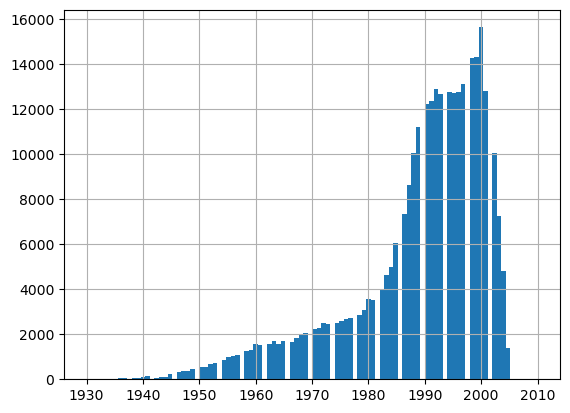

In [41]:
teachers_info['birth_date'].hist(bins=100, range=(1930,2010));

In [42]:
teachers_info = teachers_info.query("1930 <= birth_date <= 2010")

удалили выбросы по дате рождения учителей: рассматриваем с 1930 по 2010

In [43]:
# выделяем возраст учителя:
teachers_info['birth_date'] = 2022 - teachers_info['birth_date']

In [44]:
teachers_info['birth_date'].sort_values().unique()

array([13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
       65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
       82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92])

## is_email_confirmed

In [45]:
teachers_info['is_email_confirmed'].sort_values().unique()

array([0, 1], dtype=int8)

## status_teacher_id

In [46]:
teachers_info['status_teacher_id'].sort_values().unique()

array([1, 2, 3, 4, 5, 7], dtype=int8)

In [47]:
# далее мы будет группировать данные, для этого нужен численный формат:
teachers_info['status_teacher_id'] = teachers_info['status_teacher_id'].astype('int32')

## information

In [48]:
# так как далее будет происходить группировка, нам надо узнать просто есть информация в графе или нет:
teachers_info['information'] = teachers_info['information'].astype('str')

In [49]:
teachers_info.loc[teachers_info['information'] == 'nan', 'information']= 0
teachers_info.loc[teachers_info['information'] != 0, 'information']= 1

In [50]:
teachers_info['information'] = teachers_info['information'].astype('int32')

In [51]:
teachers_info['information'].sort_values().unique()

array([0, 1])

## is_display

In [52]:
teachers_info['is_display'].sort_values().unique()

array([0, 1], dtype=int8)

## photo_path

In [53]:
teachers_info['photo_path'] = teachers_info['photo_path'].astype('str')

In [54]:
teachers_info.loc[teachers_info['photo_path'] == 'nan', 'photo_path']= 0
teachers_info.loc[teachers_info['photo_path'] != 0, 'photo_path']= 1

In [55]:
teachers_info['photo_path'] = teachers_info['photo_path'].astype('int32')

In [56]:
teachers_info['photo_path'].sort_values().unique()

array([0, 1])

## rating

In [57]:
teachers_info['rating'].sort_values().unique()

array([-100500,    -300,    -200,    -100,     -50,     -30,     -25,
           -17,     -16,     -14,     -12,     -10,      -8,      -7,
            -6,      -5,      -4,      -3,      -2,      -1,       0,
             5,       6,       7,      10])

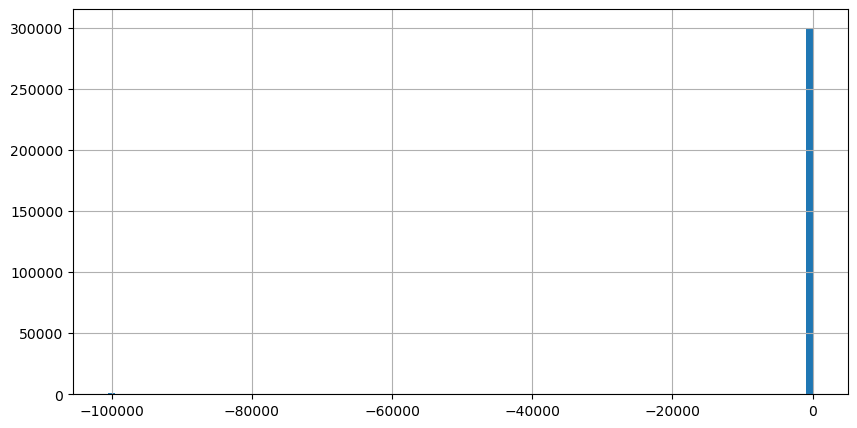

In [58]:
teachers_info['rating'].hist(bins=100, figsize=(10,5));

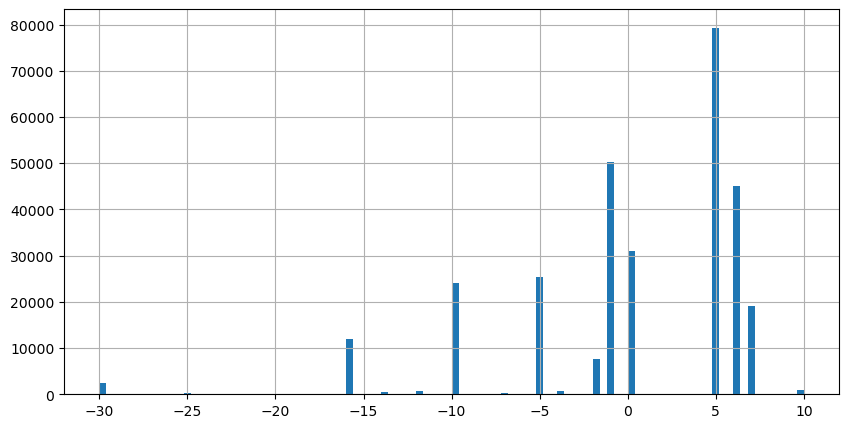

In [59]:
teachers_info['rating'].hist(bins=100, figsize=(10,5), range=(-30,10)); 

In [60]:
teachers_info.groupby('rating')['rating'].count()

rating
-100500      677
-300          63
-200          36
-100          26
-50           85
-30         2380
-25          196
-17          131
-16        11921
-14          428
-12          677
-10        24064
-8            31
-7           179
-6           107
-5         25379
-4           687
-3           137
-2          7648
-1         50330
 0         31089
 5         79345
 6         45035
 7         19139
 10          975
Name: rating, dtype: int64

Принимаю решение 'rating' рассматривать от -30 до 10

In [61]:
teachers_info = teachers_info.query("-30 <= rating <= 10")

In [62]:
teachers_info['rating'].sort_values().unique()

array([-30, -25, -17, -16, -14, -12, -10,  -8,  -7,  -6,  -5,  -4,  -3,
        -2,  -1,   0,   5,   6,   7,  10])

## is_cell_phone_confirmed

In [63]:
teachers_info['is_cell_phone_confirmed'].sort_values().unique()

array([0, 1], dtype=int8)

## effective_rating

In [64]:
teachers_info['effective_rating'].sort_values().unique()

array([-10000. ,   -997. ,   -221.8, ...,  11112. ,  11120. ,  11128. ],
      dtype=float16)

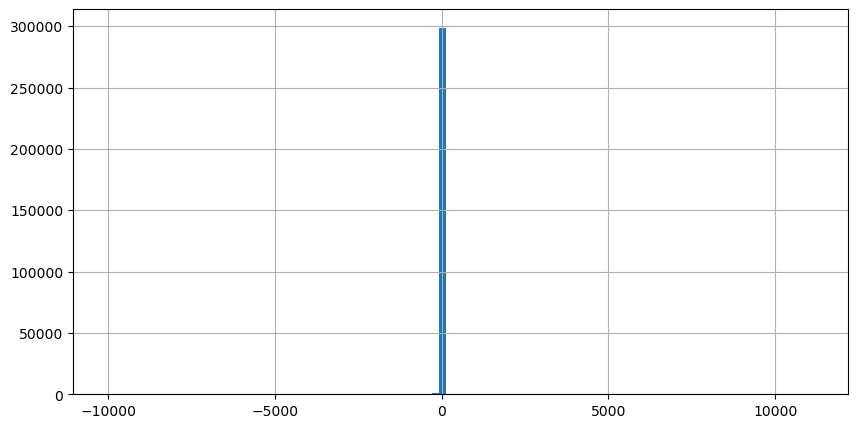

In [65]:
teachers_info['effective_rating'].hist(bins=100, figsize=(10,5));

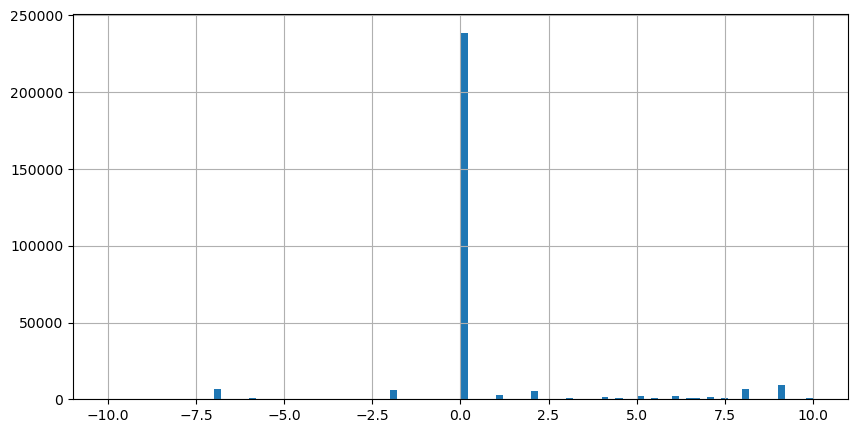

In [66]:
teachers_info.query("-10 <= effective_rating <= 10")['effective_rating'].hist(bins=100, figsize=(10,5)); 

In [67]:
teachers_info.groupby('effective_rating')['effective_rating'].count()

effective_rating
-10,000.000         1
-997.000            1
-221.750            1
-194.000            1
-177.250            1
-174.375            1
-168.250            1
-167.250            3
-158.500            1
-157.875            1
-147.500            1
-145.625            1
-145.500            1
-145.375            3
-145.000            1
-142.375            1
-136.375           20
-135.375           30
-128.625            1
-118.312            1
-117.688            1
-117.500            1
-116.438            1
-116.188            1
-114.000            1
-111.062            5
-110.625            1
-110.500            2
-110.062            8
-109.875            2
-109.500            3
-109.062            1
-108.500            1
-108.312            2
-108.125            1
-108.000            1
-107.750            2
-107.000            1
-105.000            1
-104.000           22
-103.812            1
-101.062            1
-101.000            8
-100.375            1
-99.688        

Принимаю решение 'effective_rating' рассматривать от -10 до 10

In [68]:
teachers_info = teachers_info.query("-10 <= effective_rating <= 10")

In [69]:
teachers_info['effective_rating'].sort_values().unique()

array([-10.   ,  -9.88 ,  -9.875, ...,   9.984,   9.99 ,  10.   ],
      dtype=float16)

## rating_for_users

In [70]:
pd.options.display.float_format ='{:,.3f}'.format #перевод всех чисел в тетрадке в читаемый формат

In [71]:
teachers_info['rating_for_users'].sort_values().unique()

array([0.000e+00, 1.838e+00, 2.564e+00, ..., 1.609e+04, 1.654e+04,
       1.696e+04], dtype=float16)

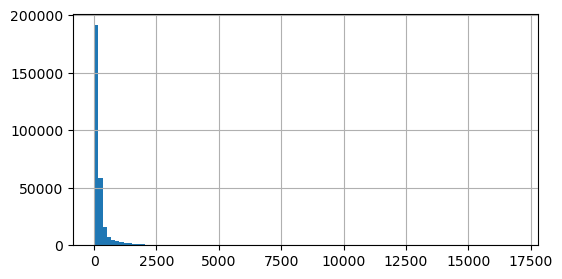

In [72]:
teachers_info['rating_for_users'].hist(bins=100, figsize=(6,3));

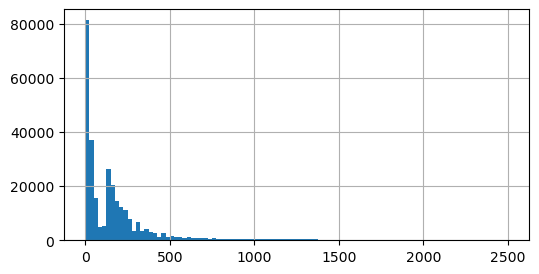

In [73]:
teachers_info['rating_for_users'].hist(bins=100, figsize=(6,3), range=(0,2500));

In [74]:
teachers_info.groupby('rating_for_users')['rating_for_users'].count()

rating_for_users
0.000         78405
1.838             1
2.564             1
4.617             1
5.000          1481
5.859             1
6.000           164
7.000            65
7.500            35
8.000            25
8.750             1
9.000             5
9.547             1
10.000          541
12.000           62
14.000           31
14.195            1
15.000          276
15.625            1
16.000           10
16.672            2
17.500            1
17.812            1
18.000           27
18.750            2
20.000          169
20.828            1
21.000           14
21.328            1
22.500           11
23.922            1
24.000           28
25.000        31382
26.250            2
26.781            1
27.000            3
27.047            1
27.500            1
28.000            6
28.750            1
29.172            1
30.000         3125
31.672            1
32.000            6
33.750            1
33.906            1
34.281            1
35.000         1153
35.875            1
35.

Принимаю решение 'rating_for_users' рассматривать от 0 до 2500

In [75]:
teachers_info = teachers_info.query("0 <= rating_for_users <= 2500")

## rating_for_admin

In [76]:
teachers_info['rating_for_admin'].sort_values().unique()

array([0.00e+00, 3.57e-02, 5.00e-02, ..., 4.20e+03, 4.35e+03, 4.50e+03],
      dtype=float16)

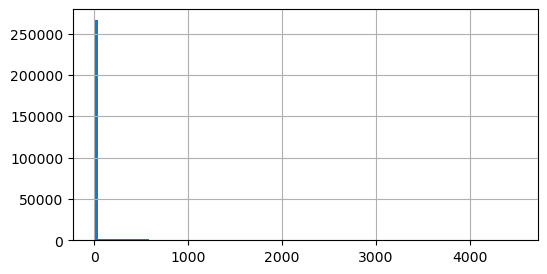

In [77]:
teachers_info['rating_for_admin'].hist(bins=100, figsize=(6,3));

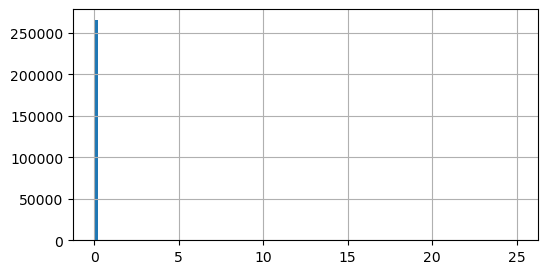

In [78]:
teachers_info['rating_for_admin'].hist(bins=100, figsize=(6,3), range=(0,25));

In [79]:
teachers_info.groupby('rating_for_admin')['rating_for_admin'].count()

rating_for_admin
0.000        265063
0.036             1
0.050             2
0.062             1
1.463             1
2.537             1
2.777             1
3.205             1
3.572             1
3.676             1
3.787             1
3.879             1
3.947             1
4.168             2
4.465             1
4.605             1
4.629             1
4.688             1
4.750             1
4.762             1
4.809             1
5.000             2
5.066             1
5.102             1
5.113             1
5.277             1
5.434             1
5.453             1
5.641             1
5.684             1
5.770             1
5.953             1
6.000             1
6.035             1
6.199             1
6.250             6
6.523             2
6.758             2
6.887             1
6.945             1
7.145             1
7.223             1
7.258             1
7.500             1
7.574             1
7.652             1
7.691             1
7.812             2
8.062             1
8.0

Принимаю решение 'rating_for_admin' оставить как есть

## display_days

In [80]:
teachers_info['display_days'].sort_values().unique()

array([0.000e+00, 5.000e-01, 1.000e+00, ..., 3.678e+03, 3.680e+03,
       3.682e+03], dtype=float16)

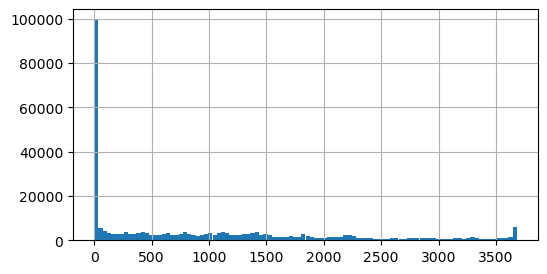

In [81]:
teachers_info['display_days'].hist(bins=100, figsize=(6,3));

In [82]:
teachers_info.groupby('display_days')['display_days'].count()

display_days
0.000        92072
0.500          277
1.000          320
1.500          155
2.000          232
2.500           94
3.000          172
3.500           98
4.000          163
4.500           80
5.000          199
5.500           74
6.000          238
6.500          115
7.000          196
7.500          103
8.000          150
8.500           46
9.000          147
9.500          112
10.000         108
10.500          46
11.000          98
11.500          47
12.000         119
12.500         110
13.000         133
13.500          58
14.000         145
14.500          30
15.000         138
15.500          42
16.000         127
16.500          30
17.000          81
17.500          27
18.000          79
18.500          62
19.000          88
19.500          86
20.000         154
20.500          37
21.000         143
21.500          43
22.000         107
22.500          57
23.000         152
23.500          26
24.000          64
24.500          27
25.000          61
25.500          31

Принимаю решение 'display_days' перевести в годы работы с сервисом

In [83]:
teachers_info['display_days'] = teachers_info['display_days']/365

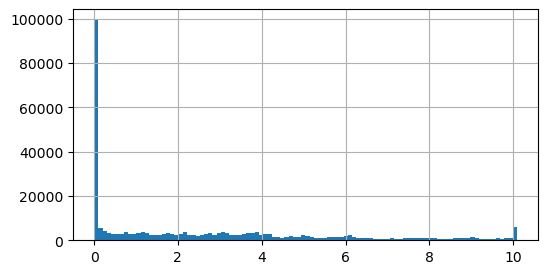

In [84]:
teachers_info['display_days'].hist(bins=100, figsize=(6,3));

## star_rating

In [85]:
teachers_info['star_rating'].sort_values().unique()

array([0. , 2.2, 2.3, 2.4, 2.5, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4,
       3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7,
       4.8, 4.9, 5. ], dtype=float16)

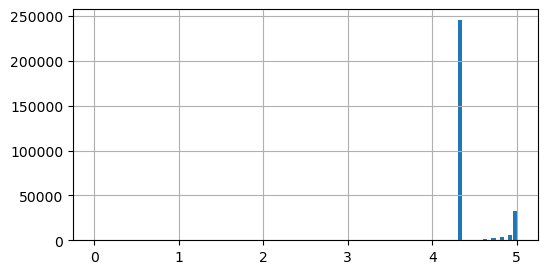

In [86]:
teachers_info['star_rating'].hist(bins=100, figsize=(6,3));

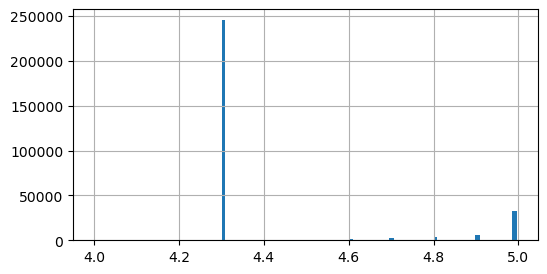

In [87]:
teachers_info['star_rating'].hist(bins=100, figsize=(6,3), range=(4,5));

In [88]:
teachers_info.groupby('star_rating')['star_rating'].count()

star_rating
0.000        44
2.199       149
2.301         1
2.400         5
2.500         4
2.699         9
2.801         2
2.900        50
3.000         2
3.100        14
3.199        15
3.301        30
3.400        24
3.500        12
3.600       176
3.699        16
3.801        44
3.900        68
4.000        59
4.102       102
4.199        64
4.301    245318
4.398       221
4.500       631
4.602      1260
4.699      1993
4.801      3957
4.898      5768
5.000     32825
Name: star_rating, dtype: int64

Принимаю решение 'star_rating' оставить как есть

## rating_for_users_yesterday

In [89]:
teachers_info['rating_for_users_yesterday'].sort_values().unique()

array([0.000e+00, 1.838e+00, 2.564e+00, ..., 2.770e+03, 3.020e+03,
       4.400e+03], dtype=float16)

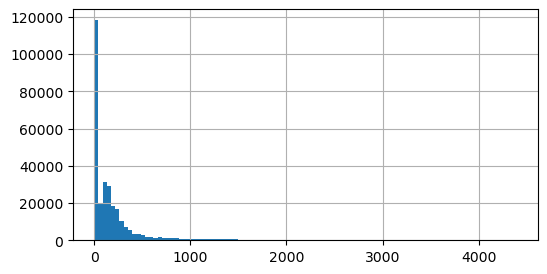

In [90]:
teachers_info['rating_for_users_yesterday'].hist(bins=100, figsize=(6,3));

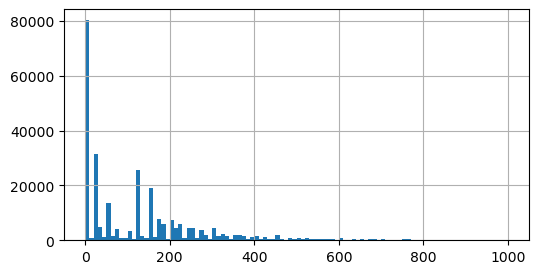

In [91]:
teachers_info['rating_for_users_yesterday'].hist(bins=100, figsize=(6,3), range=(0,1000));

In [92]:
teachers_info.groupby('rating_for_users_yesterday')['rating_for_users_yesterday'].count()

rating_for_users_yesterday
0.000        78498
1.838            1
2.564            1
4.617            1
5.000         1480
5.516            1
6.000          165
7.000           64
7.500           32
8.000           27
8.750            1
9.000            4
9.547            1
10.000         542
12.000          60
14.000          31
14.195           1
15.000         276
15.625           1
16.000          11
16.672           2
17.500           1
17.812           1
18.000          27
18.750           2
20.000         169
20.828           1
21.000          14
21.328           1
22.500          10
23.922           1
24.000          28
25.000       31382
26.250           2
26.781           1
27.000           4
27.047           1
27.500           1
28.000           7
28.750           1
29.172           1
30.000        3126
31.672           1
32.000           8
33.750           1
33.906           1
34.281           1
35.000        1148
35.875           1
35.906           1
36.000         163
36.2

Принимаю решение 'rating_for_users_yesterday' рассматривать от 0 до 1500

In [93]:
teachers_info = teachers_info.query("0 <= rating_for_users_yesterday <= 1500")

## review_num

In [94]:
teachers_info['review_num'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  62,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  80,  82,
        83,  84,  85,  86,  93,  96,  97,  98, 100, 103, 111, 114, 133,
       185, 193], dtype=int16)

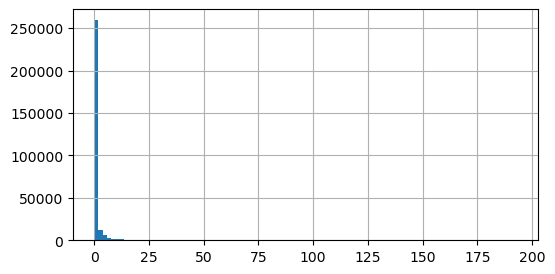

In [95]:
teachers_info['review_num'].hist(bins=100, figsize=(6,3));

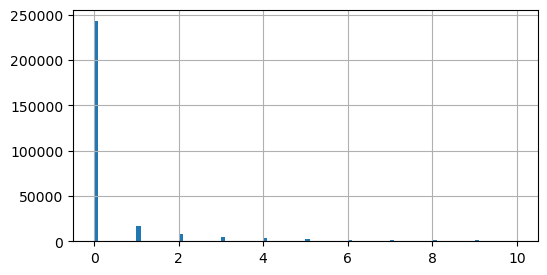

In [96]:
teachers_info['review_num'].hist(bins=100, figsize=(6,3), range=(0,10));

In [97]:
teachers_info.groupby('review_num')['review_num'].count()

review_num
0      242625
1       16738
2        7686
3        4672
4        3290
5        2352
6        1808
7        1415
8        1039
9         904
10        706
11        594
12        478
13        443
14        359
15        315
16        290
17        227
18        201
19        176
20        152
21        135
22        135
23        108
24         91
25         69
26         65
27         51
28         56
29         54
30         44
31         59
32         27
33         39
34         36
35         35
36         27
37         20
38         17
39         25
40         13
41         11
42         14
43         19
44         15
45         16
46         13
47         13
48          7
49          7
50          8
51         11
52          5
53          3
54          3
55          8
56          5
57          7
58          7
59          3
60          7
62          2
64          2
65          2
66          2
67          2
68          4
69          1
70          3
71          1
72       

Принимаю решение 'review_num' оставить как есть

Результат работы с выбросами в таблице teachers_info: 6% выборки было отбраковано.

Репетиторы (teacher_info.feather) - ОСТАВШИЕСЯ СТОЛБЦЫ:

1)  ✓ birth_date - 2021 - birth_date
2)  ✓ is_email_confirmed - да или нет
3)  ✓ status_teacher_id (1 Студент 2 Аспирант 3 Школьный преподаватель 4 Преподаватель вуза 5 Частный преподаватель 7 Носитель языка)
4)  ✓ information - комментарий учителя о себе - есть или нет
5)  ✓ is_display - показывается в каталоге - да или нет
6)  ✓ photo_path - путь для выгрузки фото преподавателя - да или нет
7)  ✓ rating - рейтинг от -30 до 10 надо почистить
8)  ✓ is_cell_phone_confirmed - подтвержденный номер телефона - да или нет
9)  ✓ effective_rating - рейтинг № 1
10) ✓ rating_for_users - рейтинг № 2
11) ✓ rating_for_admin - рейтинг № 3
12) ✓ display_days - количество дней работы на сервисе преподавателя (типа опыт) /365 будет год
13) ✓ star_rating - рейтинг № 4
14) ✓ rating_for_users_yesterday - рейтинг №5 (на вчера)
15) ✓ review_num - количество отзывов

# suitable_teachers

In [98]:
suitable_teachers=feather.read_feather('suitable_teachers.feather')
suitable_teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 5 columns):
 #   Column              Dtype   
---  ------              -----   
 0   teacher_id          int32   
 1   order_id            int32   
 2   contact_result      category
 3   enable_auto_assign  int8    
 4   enable_assign       int8    
dtypes: category(1), int32(2), int8(2)
memory usage: 232.3 MB


Подходящие по фильтру репетиторы (suitable_teachers.feather)

1. teacher_id - id репетитора
2. order_id - id заявки
3. contact_result  - это коммент по установлению связи с репетитором (на момент подачи заявки неизвестно)
4. enable_auto_assign - доступен ли репетитор к работе или заблокирован (может ли репетитора назначить консультант и может ли он сам назначиться) (значение известно на момент подачи заявки)
5. enable_assign - доступен ли репетитор к работе или заблокирован (может ли репетитора назначить консультант и может ли он сам назначиться) (значение известно на момент подачи заявки)

In [99]:
suitable_teachers.head()

,teacher_id,order_id,contact_result,enable_auto_assign,enable_assign
0,82583,1742711,Репетитор согласился,1,1
1,125057,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
2,231211,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
3,128773,1742713,"Репетитор положил трубку, либо обрыв связи (Ok...",0,0
4,63019,1742713,Репетитор согласился,0,1


In [100]:
## contact_result - не известно при подаче заявки
suitable_teachers = suitable_teachers.drop(columns = ['contact_result'], axis = 1)

In [101]:
suitable_teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20271186 entries, 0 to 20271185
Data columns (total 4 columns):
 #   Column              Dtype
---  ------              -----
 0   teacher_id          int32
 1   order_id            int32
 2   enable_auto_assign  int8 
 3   enable_assign       int8 
dtypes: int32(2), int8(2)
memory usage: 193.3 MB


# merge teachers_info c suitable_teachers

In [102]:
%%time
suitable_teachers = suitable_teachers.merge(teachers_info, on='teacher_id', how='left')

Wall time: 1min 12s


In [103]:
suitable_teachers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20271186 entries, 0 to 20271185
Data columns (total 83 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   teacher_id                  int32   
 1   order_id                    int32   
 2   enable_auto_assign          int8    
 3   enable_assign               int8    
 4   date_update                 category
 5   reg_date                    category
 6   birth_date                  float64 
 7   teaching_start_date         category
 8   user_id                     float64 
 9   is_email_confirmed          float64 
 10  is_home_lessons             float64 
 11  is_external_lessons         float64 
 12  external_comments           category
 13  lesson_duration             float64 
 14  lesson_cost                 float64 
 15  status_teacher_id           float64 
 16  status_relevant_date        category
 17  status_school_id            float16 
 18  status_college_id           float16 
 19

Репетиторы (teacher_info.feather) - ОСТАВШИЕСЯ СТОЛБЦЫ:

1)  ✓ birth_date - 2021 - birth_date
2)  ✓ is_email_confirmed - да или нет
3)  ✓ status_teacher_id (1 Студент 2 Аспирант 3 Школьный преподаватель 4 Преподаватель вуза 5 Частный преподаватель 7 Носитель языка)
4)  ✓ information - комментарий учителя о себе - есть или нет
5)  ✓ is_display - показывается в каталоге - да или нет
6)  ✓ photo_path - путь для выгрузки фото преподавателя - да или нет
7)  ✓ rating - рейтинг от -30 до 10 надо почистить
8)  ✓ is_cell_phone_confirmed - подтвержденный номер телефона - да или нет
9)  ✓ effective_rating - рейтинг № 1
10) ✓ rating_for_users - рейтинг № 2
11) ✓ rating_for_admin - рейтинг № 3
12) ✓ display_days - количество дней работы на сервисе преподавателя (типа опыт) /365 будет год
13) ✓ star_rating - рейтинг № 4
14) ✓ rating_for_users_yesterday - рейтинг №5 (на вчера)
15) ✓ review_num - количество отзывов

In [104]:
%%time
suitable_teachers = suitable_teachers[['order_id', 'enable_auto_assign', 'enable_assign',\
                                       'birth_date', 'is_email_confirmed', \
                                        'status_teacher_id', 'information', 'is_display', \
                                        'photo_path', 'rating', 'is_cell_phone_confirmed',\
                                        'effective_rating', 'rating_for_users',\
                                        'rating_for_admin', 'display_days', 'star_rating',\
                                        'rating_for_users_yesterday', 'review_num']]

In [105]:
# перед группировкой все данные(которые можно сгруппировать) должны быть численные:
suitable_teachers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20271186 entries, 0 to 20271185
Data columns (total 18 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   order_id                    int32  
 1   enable_auto_assign          int8   
 2   enable_assign               int8   
 3   birth_date                  float64
 4   is_email_confirmed          float64
 5   status_teacher_id           float64
 6   information                 float64
 7   is_display                  float64
 8   photo_path                  float64
 9   rating                      float64
 10  is_cell_phone_confirmed     float64
 11  effective_rating            float16
 12  rating_for_users            float16
 13  rating_for_admin            float16
 14  display_days                float32
 15  star_rating                 float16
 16  rating_for_users_yesterday  float16
 17  review_num                  float64
dtypes: float16(5), float32(1), float64(9), int32(1), int8(2)
mem

## Группировка 

In [106]:
group_suitable_teachers = suitable_teachers.groupby('order_id').mean()

In [107]:
group_suitable_teachers.head(10)

,enable_auto_assign,enable_assign,birth_date,is_email_confirmed,status_teacher_id,information,is_display,photo_path,rating,is_cell_phone_confirmed,effective_rating,rating_for_users,rating_for_admin,display_days,star_rating,rating_for_users_yesterday,review_num
order_id,,,,,,,,,,,,,,,,,
1742638,0.538,0.000,26.000,0.000,3.778,0.667,0.667,1.000,5.333,0.000,0.000,652.000,376.000,4.877,4.680,652.000,4.667
1742639,1.000,1.000,33.000,0.000,7.000,0.000,1.000,1.000,6.000,0.000,0.000,805.500,614.000,3.019,4.898,805.500,6.000
1742650,0.667,0.333,35.667,0.000,5.000,1.000,1.000,0.667,5.667,0.000,0.000,591.500,301.500,4.193,4.766,591.500,2.333
1742651,1.000,0.000,48.500,0.000,3.000,0.500,1.000,0.500,5.500,0.000,4.000,"1,080.000","1,325.000",7.740,4.949,"1,080.000",18.000
1742654,0.750,0.000,40.250,0.000,3.500,0.500,0.500,1.000,2.750,0.000,1.500,603.000,510.500,3.643,4.801,603.000,6.500
1742655,0.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1742661,0.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1742662,0.182,0.091,29.500,0.000,5.000,0.700,0.900,1.000,4.600,0.000,0.000,196.000,0.000,3.320,4.371,196.000,0.200
1742663,0.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
group_suitable_teachers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842019 entries, 1742638 to 2946699
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   enable_auto_assign          842019 non-null  float64
 1   enable_assign               842019 non-null  float64
 2   birth_date                  777738 non-null  float64
 3   is_email_confirmed          777738 non-null  float64
 4   status_teacher_id           777738 non-null  float64
 5   information                 777738 non-null  float64
 6   is_display                  777738 non-null  float64
 7   photo_path                  777738 non-null  float64
 8   rating                      777738 non-null  float64
 9   is_cell_phone_confirmed     777738 non-null  float64
 10  effective_rating            777738 non-null  float16
 11  rating_for_users            777738 non-null  float16
 12  rating_for_admin            777738 non-null  float16
 13  display

In [109]:
suitable_teachers.groupby('order_id').mean().describe()

,enable_auto_assign,enable_assign,birth_date,is_email_confirmed,status_teacher_id,information,is_display,photo_path,rating,is_cell_phone_confirmed,effective_rating,rating_for_users,rating_for_admin,display_days,star_rating,rating_for_users_yesterday,review_num
count,"842,019.000","842,019.000","777,738.000","777,738.000","777,738.000","777,738.000","777,738.000","777,738.000","777,738.000","777,738.000","777,738.000","777,738.000","777,738.000","777,738.000","777,738.000","777,738.000","777,738.000"
mean,0.245,0.102,36.239,0.021,4.257,0.598,0.949,0.901,5.377,0.011,NaN,NaN,NaN,4.754,NaN,NaN,6.712
std,0.366,0.219,8.564,0.074,0.869,0.264,0.108,0.160,1.199,0.051,0.000,NaN,NaN,1.716,0.000,NaN,8.278
min,0.000,0.000,17.000,0.000,1.000,0.000,0.000,0.000,-30.000,0.000,-10.000,0.000,0.000,0.000,2.199,0.000,0.000
25%,0.000,0.000,30.333,0.000,3.816,0.462,0.931,0.857,5.000,0.000,0.000,358.500,110.625,3.638,4.535,358.750,1.750
50%,0.016,0.023,35.300,0.000,4.391,0.609,1.000,0.978,5.556,0.000,0.366,569.000,247.125,4.654,4.699,569.000,4.120
75%,0.417,0.083,41.000,0.000,4.852,0.759,1.000,1.000,6.000,0.000,1.272,909.500,439.000,5.763,4.867,910.000,8.741
max,1.000,1.000,87.000,1.000,7.000,1.000,1.000,1.000,10.000,1.000,10.000,"2,500.000","2,624.000",10.088,5.000,"1,500.000",193.000


# merge group_suitable_teachers c orders_2

In [110]:
%%time
orders_2 = orders_2.merge(group_suitable_teachers, on='order_id', how='left')

Wall time: 4.53 s


In [111]:
orders_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190961 entries, 0 to 1190960
Data columns (total 55 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   index                       1190961 non-null  int64  
 1   order_id                    1190961 non-null  int64  
 2   order_date                  1190961 non-null  object 
 3   subject_id                  1180636 non-null  float32
 4   purpose                     1024538 non-null  object 
 5   lesson_price                1190961 non-null  int32  
 6   lesson_duration             1190961 non-null  int32  
 7   lesson_place                31 non-null       object 
 8   home_metro_id               642009 non-null   float32
 9   add_info                    1043862 non-null  object 
 10  start_date                  705101 non-null   object 
 11  working_teacher_id          705511 non-null   float32
 12  status_id                   1190961 non-null  int32  
 1

Данные из таблицы orders:

order_id - id заявки - не информативный признак 

status_id - оплачена ли заявка - целевой признак

1. subject_id - предмет ✓
2. purpose - цель занятий(заполняет клиент) ✓
3. lesson_price - цена ✓ 10 000 и выше - это выброс (цена ДО)
4. lesson_duration - желаемая проодолжительность урока ✓
5. home_metro_id - ближайшее метро ✓
6. add_info - доп инфо (заполняет инфо) ✓
7. planned_lesson_number - клиент планирует N занятий ✓
8. pupil_category_new_id - возраст ученика ✓
9. lessons_per_week - занятий а неделю ✓
10. minimal_price ✓ ЦЕНА ОТ (клиент указывает диапазон цен)-все что выше 5000 надо убрать как выброс
11. teacher_sex - пол репетитора ✓ 1 - м, 2 - ж, 0 и 3 нужно объединить в неизвестный
12. teacher_experience_from - опыт репетитора от ✓
13. teacher_experience_to- опыт репетитора до ✓
14. lesson_place_new - онлайн, у ученика, у учителя ✓
15. pupil_knowledgelvl -уровень знаний ученика ✓
16. teacher_age_from - желаемый возраст репеитора от ✓
17. teacher_age_to - желаемый возраст репеитора от ✓
18. chosen_teachers_only - не предлагать репетиторов кроме выбранных самостоятельно ✓
19. no_teachers_available - есть ли подходящие репетиторы по заявке (да/нет) ✓
20. is_display_to_teachers - хочет ли клиент получать отклики репетиторов ✓

Не знаю что это за признаки и как ими воспользоваться (мб на будущие эксперименты):
? не понятно значечние признака ? source_id - где создана заявка (какая часть сайта, не регион) ✓
? где этот показатель в данных, а что он означает ? coef - коэффициент ✓


Репетиторы (teacher_info.feather)

1.  ✓ birth_date - 2021 - birth_date
2.  ✓ is_email_confirmed - да или нет
3.  ✓ status_teacher_id (1 Студент 2 Аспирант 3 Школьный преподаватель 4 Преподаватель вуза 5 Частный преподаватель 7 Носитель языка)
4.  ✓ information - комментарий учителя о себе - есть или нет
5.  ✓ is_display - показывается в каталоге - да или нет
6.  ✓ photo_path - путь для выгрузки фото преподавателя - да или нет
7.  ✓ rating - рейтинг от -30 до 10 надо почистить
8.  ✓ is_cell_phone_confirmed - подтвержденный номер телефона - да или нет
9.  ✓ effective_rating - рейтинг № 1
10. ✓ rating_for_users - рейтинг № 2
11. ✓ rating_for_admin - рейтинг № 3
12. ✓ display_days - количество дней работы на сервисе преподавателя (типа опыт) /365 будет год
13. ✓ star_rating - рейтинг № 4
14. ✓ rating_for_users_yesterday - рейтинг №5 (на вчера)
15. ✓ review_num - количество отзывов

In [112]:
orders_2 = orders_2[['order_id', 'status_id', 'subject_id', 'purpose', 'add_info', 'lesson_price', 'lesson_duration', 'home_metro_id',\
                     'planned_lesson_number', 'pupil_category_new_id', 'lessons_per_week', 'minimal_price',\
                     'teacher_sex', 'teacher_experience_from', 'teacher_experience_to', 'lesson_place_new',\
                     'pupil_knowledgelvl', 'teacher_age_from', 'teacher_age_to', 'chosen_teachers_only',\
                     'no_teachers_available', 'is_display_to_teachers',\
                     'enable_auto_assign', 'enable_assign',\
                     'birth_date', 'is_email_confirmed', 'status_teacher_id', 'information', 'is_display', \
                     'photo_path', 'rating', 'is_cell_phone_confirmed','effective_rating', 'rating_for_users',\
                     'rating_for_admin', 'display_days', 'star_rating', 'rating_for_users_yesterday', 'review_num']]

# Работа с признаками в orders_2

In [113]:
orders_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190961 entries, 0 to 1190960
Data columns (total 39 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   order_id                    1190961 non-null  int64  
 1   status_id                   1190961 non-null  int32  
 2   subject_id                  1180636 non-null  float32
 3   purpose                     1024538 non-null  object 
 4   add_info                    1043862 non-null  object 
 5   lesson_price                1190961 non-null  int32  
 6   lesson_duration             1190961 non-null  int32  
 7   home_metro_id               642009 non-null   float32
 8   planned_lesson_number       1190961 non-null  int32  
 9   pupil_category_new_id       1031655 non-null  float32
 10  lessons_per_week            1190961 non-null  int32  
 11  minimal_price               1190961 non-null  int32  
 12  teacher_sex                 1190961 non-null  int32  
 1

## subject_id

In [114]:
orders_2['subject_id'] = orders_2['subject_id'].fillna(0)
orders_2['subject_id'] = orders_2['subject_id'].astype('int32')
orders_2['subject_id'].sort_values().unique()

array([      0,       1,       2,       3,       4,       5,       6,
             7,       8,       9,      10,      11,      12,      13,
            14,      15,      16,      17,      18,      19,      20,
            21,      23,      25,      27,      29,      33,      36,
       3211265, 3342337, 3605505])

## purpose

In [115]:
orders_2['purpose'] = orders_2['purpose'].fillna(0)

## lesson_price

In [116]:
orders_2['lesson_price'].sort_values().unique()

array([         0,          1,          2,          3,          4,
                5,         10,         11,         12,         15,
               17,         18,         20,         22,         24,
               25,         30,         35,         36,         40,
               45,         50,         55,         60,         70,
               85,         90,        100,        109,        110,
              120,        128,        130,        150,        170,
              200,        210,        250,        260,        290,
              300,        320,        340,        350,        360,
              370,        375,        380,        383,        390,
              397,        400,        410,        413,        430,
              435,        440,        442,        450,        462,
              470,        473,        480,        485,        490,
              499,        500,        501,        509,        520,
              522,        525,        530,        531,        

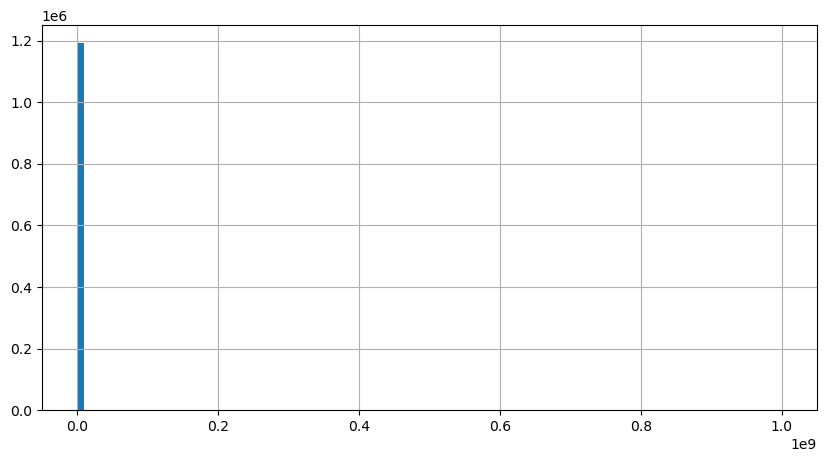

In [117]:
orders_2['lesson_price'].hist(bins=100, figsize=(10,5));

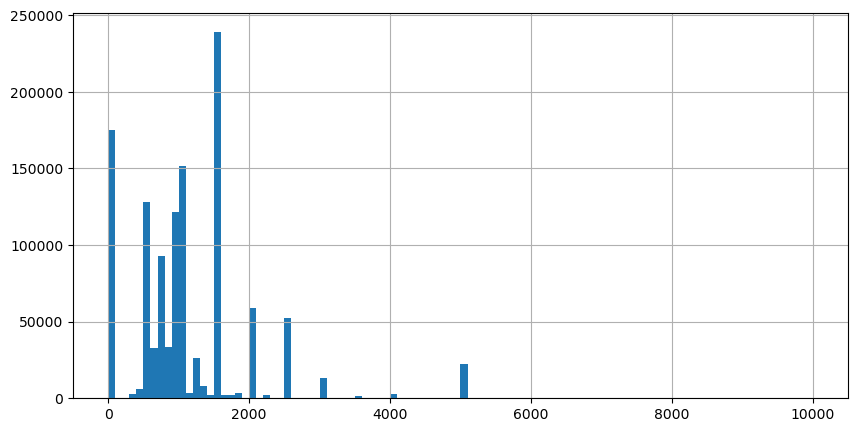

In [118]:
orders_2['lesson_price'].hist(bins=100, figsize=(10,5), range=(0,10000)); 

In [119]:
orders_2.groupby('lesson_price')['lesson_price'].count()

lesson_price
0             175011
1                 19
2                  8
3                  3
4                  1
5                  2
10                10
11                 1
12                 1
15                 5
17                 1
18                 2
20                 9
22                 1
24                 2
25                 4
30                10
35                 2
36                 1
40                 2
45                 1
50                14
55                 1
60                 2
70                 1
85                 1
90                 5
100               33
109                1
110                1
120                3
128                1
130                2
150               19
170                3
200               68
210                1
250              160
260                2
290                1
300             1690
320                2
340                1
350             1184
360                3
370                6
375               15


Принимаю решение 'lesson_price' рассматривать от 0 до 10000

In [120]:
orders_2 = orders_2.query("0 <= lesson_price <= 10000")

## lesson_duration

In [121]:
orders_2['lesson_duration'].sort_values().unique()

array([  0,  45,  60,  90, 120, 135])

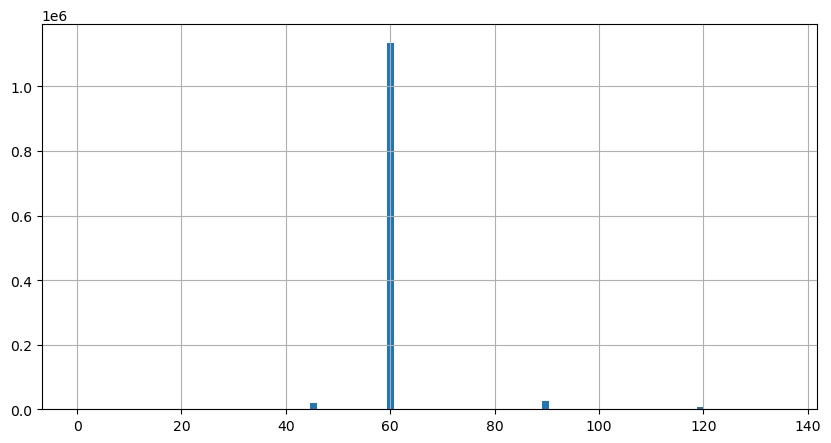

In [122]:
orders_2['lesson_duration'].hist(bins=100, figsize=(10,5));

In [123]:
orders_2.groupby('lesson_duration')['lesson_duration'].count()

lesson_duration
0         1788
45       19900
60     1135516
90       25628
120       7204
135        192
Name: lesson_duration, dtype: int64

Принимаю решение 'lesson_duration' оставить как есть

## home_metro_id

In [124]:
orders_2['home_metro_id'].sort_values().unique()

array([1.000e+00, 3.000e+00, 4.000e+00, ..., 2.702e+03, 2.704e+03,
             nan], dtype=float32)

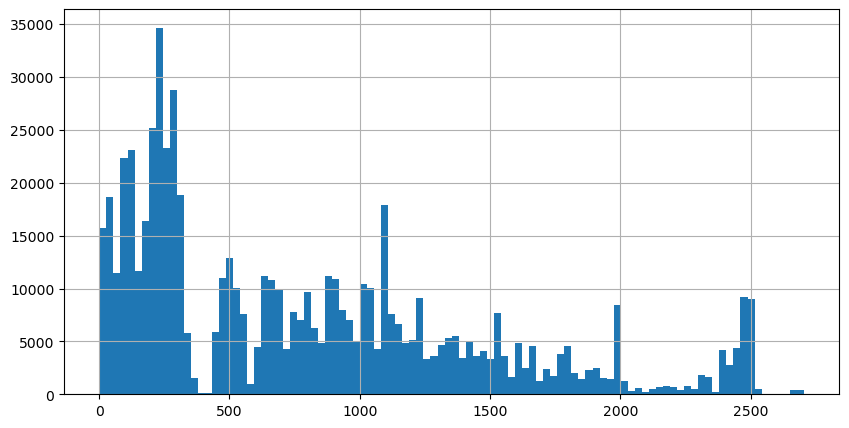

In [125]:
orders_2['home_metro_id'].hist(bins=100, figsize=(10,5));

Принимаю решение 'home_metro_id' оставить как есть

In [126]:
orders_2['home_metro_id'] = orders_2['home_metro_id'].fillna(0) 

## add_info

In [127]:
orders_2['add_info'] = orders_2['add_info'].fillna(0) 

## planned_lesson_number

In [128]:
orders_2['planned_lesson_number'].sort_values().unique()

array([ 0,  1,  2,  7, 10])

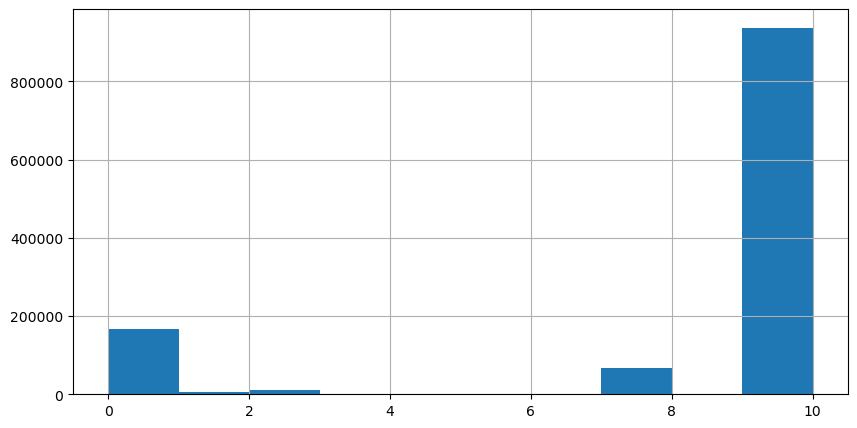

In [129]:
orders_2['planned_lesson_number'].hist(bins=10, figsize=(10,5));

Принимаю решение 'planned_lesson_number' оставить как есть

## pupil_category_new_id

In [130]:
# возраст ученика
orders_2['pupil_category_new_id'] = orders_2['pupil_category_new_id'].fillna(0)

In [131]:
orders_2['pupil_category_new_id'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       14., 15., 16., 17.], dtype=float32)

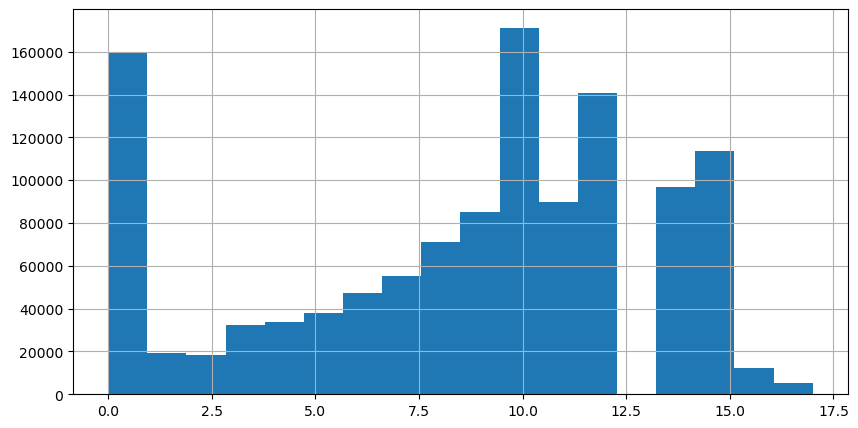

In [132]:
orders_2['pupil_category_new_id'].hist(bins=18, figsize=(10,5));

In [133]:
orders_2.groupby('pupil_category_new_id')['pupil_category_new_id'].count()

pupil_category_new_id
0.000     159284
1.000      19142
2.000      18182
3.000      32599
4.000      33644
5.000      38087
6.000      47222
7.000      55415
8.000      71117
9.000      85258
10.000    171337
11.000     90039
12.000    140823
14.000     97085
15.000    113648
16.000     12296
17.000      5050
Name: pupil_category_new_id, dtype: int64

Принимаю решение 'pupil_category_new_id' оставить как есть

## lessons_per_week

In [134]:
orders_2['lessons_per_week'].sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

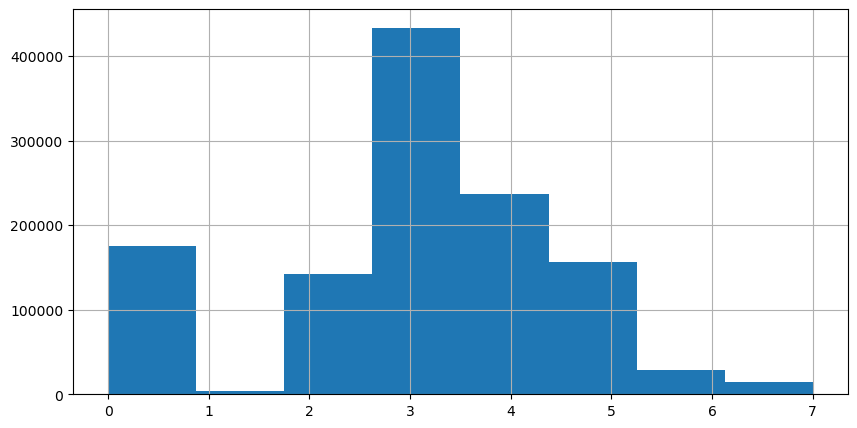

In [135]:
orders_2['lessons_per_week'].hist(bins=8, figsize=(10,5));

In [136]:
orders_2.groupby('lessons_per_week')['lessons_per_week'].count()

lessons_per_week
0    175110
1      3865
2    142337
3    433514
4    236220
5    156252
6     28165
7     14765
Name: lessons_per_week, dtype: int64

Принимаю решение 'lessons_per_week' оставить как есть

## minimal_price

In [137]:
orders_2['minimal_price'].sort_values().unique()

array([      0,       1,       2,       3,       5,       8,      10,
            11,      14,      15,      20,      22,      25,      30,
            40,      50,      60,      70,      75,      80,     100,
           120,     124,     150,     199,     200,     209,     210,
           250,     260,     290,     295,     300,     309,     324,
           333,     336,     340,     350,     370,     385,     399,
           400,     409,     410,     442,     450,     460,     500,
           509,     545,     550,     580,     590,     599,     600,
           633,     650,     670,     688,     690,     699,     700,
           701,     710,     730,     750,     800,     850,     884,
           900,     950,     999,    1000,    1009,    1050,    1100,
          1111,    1150,    1200,    1250,    1300,    1350,    1400,
          1450,    1500,    1501,    1600,    1700,    1800,    1850,
          1900,    1950,    1999,    2000,    2100,    2200,    2250,
          2300,    2

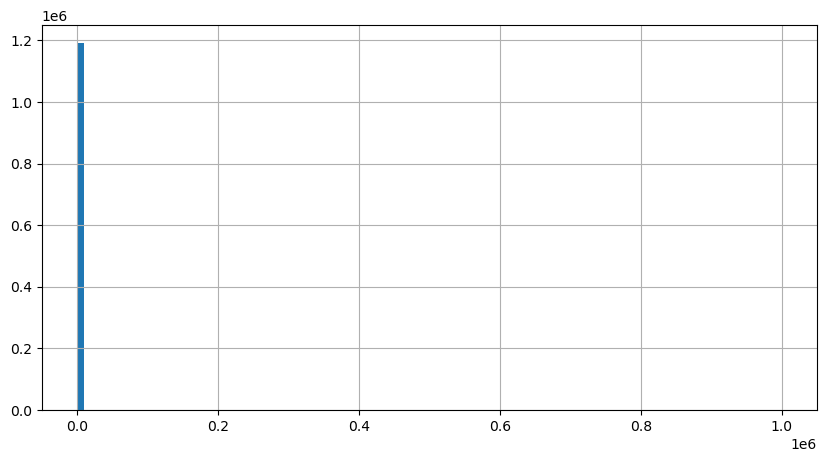

In [138]:
orders_2['minimal_price'].hist(bins=100, figsize=(10,5));

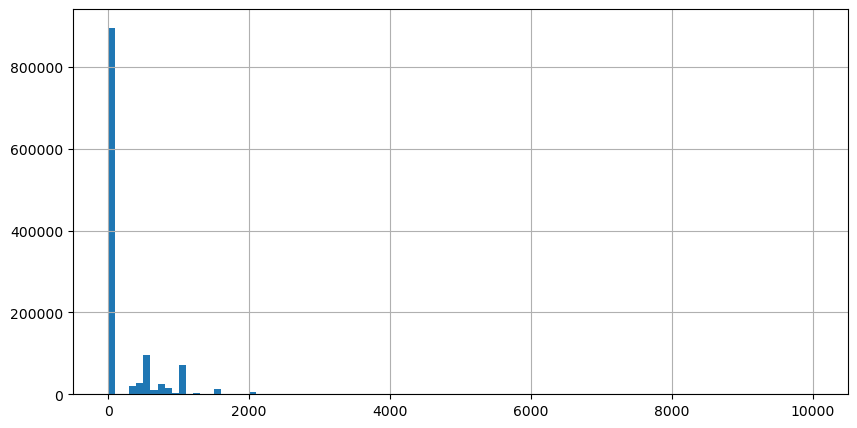

In [139]:
orders_2['minimal_price'].hist(bins=100, figsize=(10,5), range=(0,10000)); 

In [140]:
orders_2.groupby('minimal_price')['minimal_price'].count()

minimal_price
0          895997
1             190
2               3
3               2
5               6
8               1
10             23
11              1
14              1
15              9
20             10
22              1
25              9
30              6
40             16
50             50
60             36
70              8
75              1
80              6
100           810
120             1
124             1
150            42
199             1
200           925
209             1
210             2
250           545
260             1
290             1
295             1
300         18467
309             1
324             2
333             1
336             3
340             2
350          1247
370             1
385             1
399            10
400         28099
409             2
410             2
442             1
450           480
460             5
500         95087
509             1
545             1
550           102
580             1
590             1
599           

Принимаю решение 'minimal_price' рассматривать от 0 до 10000

In [141]:
orders_2 = orders_2.query("0 <= minimal_price <= 10000")

## teacher_sex

In [142]:
orders_2['teacher_sex'].sort_values().unique()

array([0, 1, 2, 3])

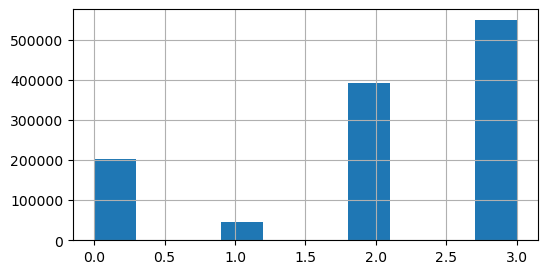

In [143]:
orders_2['teacher_sex'].hist(bins=10, figsize=(6,3));

In [144]:
orders_2.groupby('teacher_sex')['teacher_sex'].count()

teacher_sex
0    203545
1     45997
2    391811
3    548832
Name: teacher_sex, dtype: int64

In [145]:
orders_2.loc[orders_2['teacher_sex'] == 0, 'teacher_sex']= 3

In [146]:
orders_2['teacher_sex'] = orders_2['teacher_sex'].astype('int32')
orders_2['teacher_sex'].sort_values().unique()

array([1, 2, 3])

## teacher_experience_from

In [147]:
## похоже это годы
orders_2['teacher_experience_from'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 35,
       36, 37, 40, 49, 50, 51])

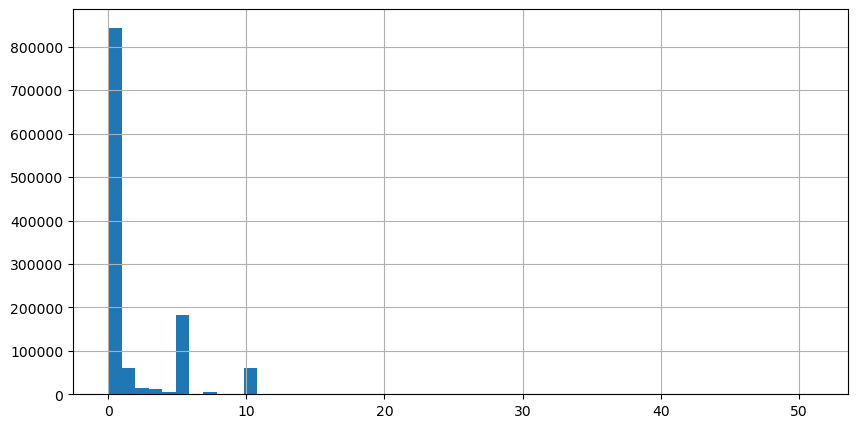

In [148]:
orders_2['teacher_experience_from'].hist(bins=52, figsize=(10,5));

In [149]:
orders_2.groupby('teacher_experience_from')['teacher_experience_from'].count()

teacher_experience_from
0     844176
1      61234
2      13683
3      13019
4       5336
5     183540
6       1155
7       5037
8        883
9         64
10     60739
11        26
12        33
13        15
14         6
15       673
16         3
17         1
18         7
19         4
20       368
21         3
22         8
23         9
24        11
25        54
26         4
27         4
28         5
29         2
30        63
32         3
33         1
35         4
36         2
37         1
40         3
49         1
50         2
51         3
Name: teacher_experience_from, dtype: int64

Принимаю решение 'teacher_experience_from' оставить как есть

## teacher_experience_to

In [150]:
orders_2['teacher_experience_to'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  55,  60,
        65,  66,  70,  75,  80,  81,  82,  85,  88,  90,  99, 100, 500])

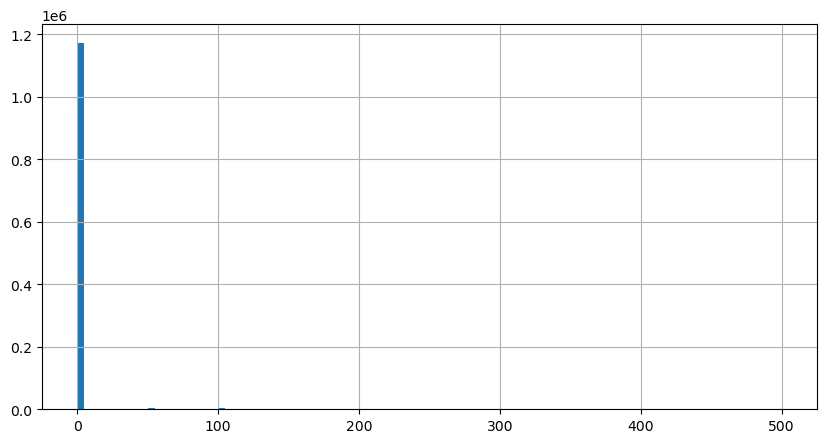

In [151]:
orders_2['teacher_experience_to'].hist(bins=100, figsize=(10,5));

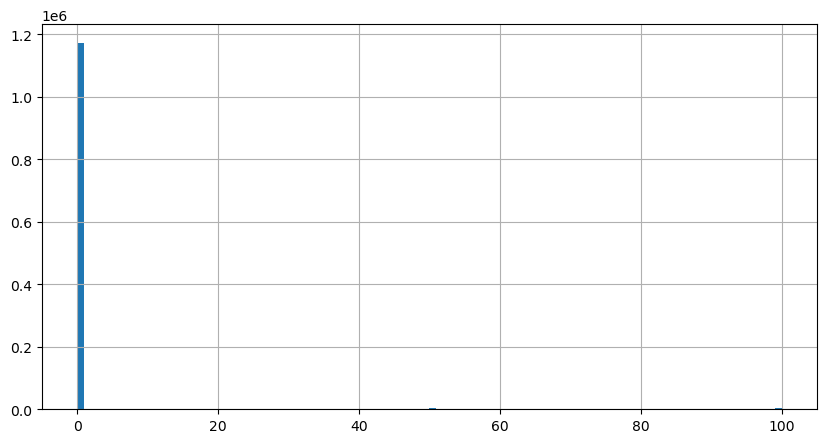

In [152]:
orders_2['teacher_experience_to'].hist(bins=100, figsize=(10,5), range=(0,100)); 

In [153]:
orders_2.groupby('teacher_experience_to')['teacher_experience_to'].count()

teacher_experience_to
0      1172986
1           58
2            1
3           10
4            4
5         1026
6            6
7            6
8            6
9            1
10        1933
12          29
13           2
14           2
15          28
16           3
17          10
18           4
19           1
20         129
21           5
22          16
23           3
24           4
25          32
26           1
27          11
28           5
29           4
30         270
31           1
32          30
33           3
34           1
35          54
36           1
37           3
38           2
39           3
40         194
41           5
42          26
43           2
44           2
45          26
46           3
47           3
48           3
49           9
50        3426
55         159
60        1457
65          48
66           2
70        1381
75           3
80        1156
81         100
82           1
85           3
88           1
90         579
99           1
100       4900
500          1
Nam

Принимаю решение 'teacher_experience_to' рассматривать от 0 до 100

In [154]:
orders_2 = orders_2.query("0 <= teacher_experience_to <= 100")

## lesson_place_new

In [155]:
orders_2['lesson_place_new'].sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

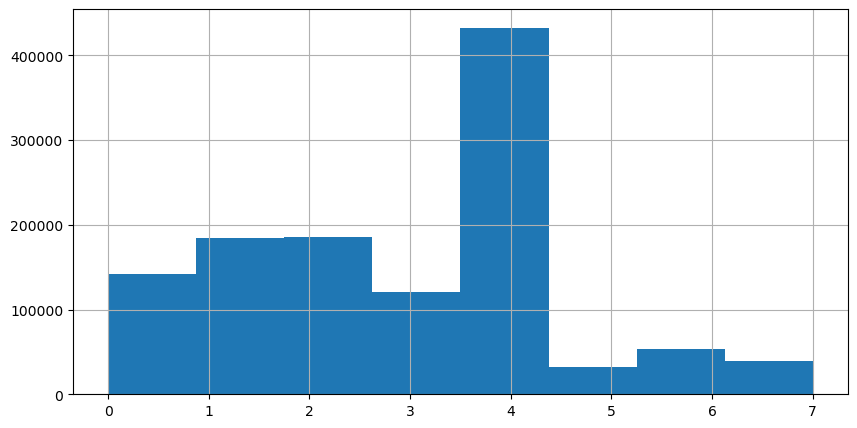

In [156]:
orders_2['lesson_place_new'].hist(bins=8, figsize=(10,5));

In [157]:
orders_2.groupby('lesson_place_new')['lesson_place_new'].count()

lesson_place_new
0    141979
1    184292
2    186178
3    120726
4    432869
5     31734
6     53690
7     38716
Name: lesson_place_new, dtype: int64

Принимаю решение 'lesson_place_new' оставить как есть

In [158]:
orders_2['lesson_place_new'] = orders_2['lesson_place_new'].astype('int32')
orders_2['lesson_place_new'].sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

## pupil_knowledgelvl

In [159]:
orders_2['pupil_knowledgelvl'].sort_values().unique()

array([0, 1, 2, 3, 4])

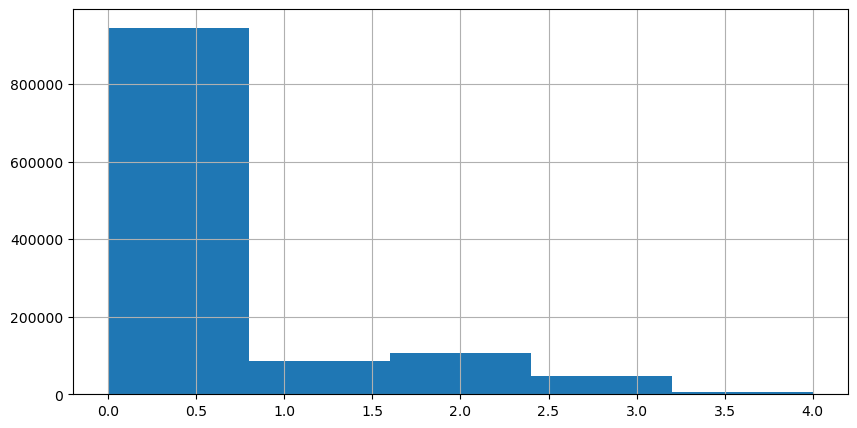

In [160]:
orders_2['pupil_knowledgelvl'].hist(bins=5, figsize=(10,5));

In [161]:
orders_2.groupby('pupil_knowledgelvl')['pupil_knowledgelvl'].count()

pupil_knowledgelvl
0    946160
1     85208
2    105291
3     46802
4      6723
Name: pupil_knowledgelvl, dtype: int64

Принимаю решение 'pupil_knowledgelvl' оставить как есть и оставить тип данных как числовые

## teacher_age_from

In [162]:
orders_2['teacher_age_from'].sort_values().unique()

array([ -40,  -27,  -20,    0,    1,    2,    3,    4,    5,    6,    7,
          8,    9,   10,   11,   12,   13,   14,   15,   16,   17,   18,
         19,   20,   21,   22,   23,   24,   25,   26,   27,   28,   29,
         30,   31,   32,   33,   34,   35,   36,   37,   38,   39,   40,
         41,   42,   43,   44,   45,   46,   47,   48,   49,   50,   51,
         52,   54,   55,   56,   57,   58,   59,   60,   65,   70,   72,
         73,   75,   76,   79,   80,   86,   89,   90,  124,  150,  220,
        222,  240,  250, 1000, 2755, 4016])

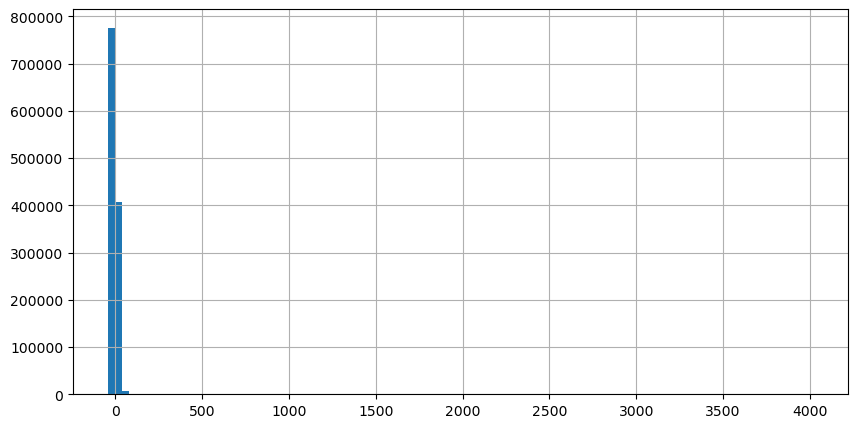

In [163]:
orders_2['teacher_age_from'].hist(bins=100, figsize=(10,5));

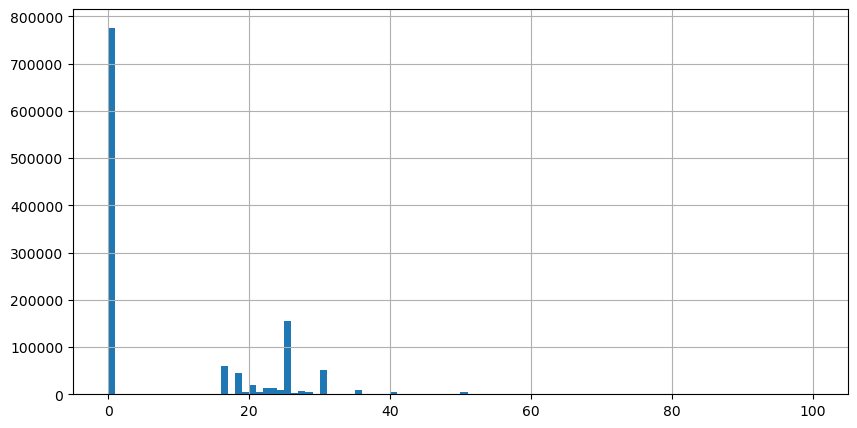

In [164]:
orders_2['teacher_age_from'].hist(bins=100, figsize=(10,5), range=(0,100)); 

In [165]:
orders_2.groupby('teacher_age_from')['teacher_age_from'].count()

teacher_age_from
-40           2
-27           1
-20           2
 0       776163
 1           39
 2           61
 3           22
 4            9
 5           55
 6            4
 7            4
 8            5
 9            7
 10          63
 11           5
 12          13
 13           8
 14          38
 15          74
 16       60210
 17         133
 18       44701
 19        4629
 20       20218
 21        3828
 22       12664
 23       13294
 24        9574
 25      154770
 26        3545
 27        7729
 28        5341
 29         521
 30       50946
 31          76
 32         216
 33         178
 34          77
 35        8211
 36         103
 37         128
 38         236
 39          55
 40        5795
 41          14
 42          23
 43          23
 44          20
 45        1213
 46          11
 47          17
 48          19
 49           5
 50        4905
 51           2
 52           7
 54           6
 55          29
 56           5
 57           5
 58           2
 59    

Принимаю решение 'teacher_age_from' рассматривать от 0 до 90

In [166]:
orders_2 = orders_2.query("0 <= teacher_age_from <= 90")

## teacher_age_to

In [167]:
orders_2['teacher_age_to'].sort_values().unique()

array([  -65,   -60,   -50,   -10,    -2,     0,     3,     4,     5,
           6,     8,     9,    10,    11,    12,    13,    14,    15,
          16,    17,    18,    19,    20,    21,    22,    23,    24,
          25,    26,    27,    28,    29,    30,    31,    32,    33,
          34,    35,    36,    37,    38,    39,    40,    41,    42,
          43,    44,    45,    46,    47,    48,    49,    50,    51,
          52,    53,    54,    55,    56,    57,    58,    59,    60,
          61,    62,    63,    64,    65,    66,    67,    68,    69,
          70,    71,    72,    73,    74,    75,    76,    77,    78,
          79,    80,    81,    82,    83,    84,    85,    88,    89,
          90,    95,    99,   100,   180,   228,   455,   880,  1000,
        5536, 10000, 25000, 99999])

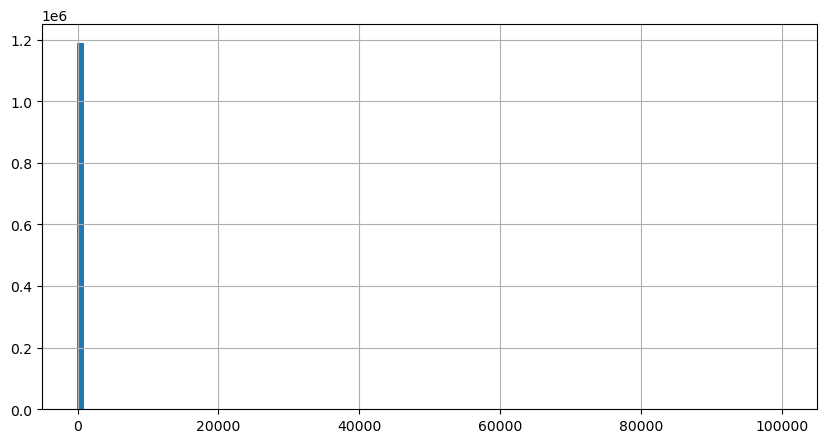

In [168]:
orders_2['teacher_age_to'].hist(bins=100, figsize=(10,5));

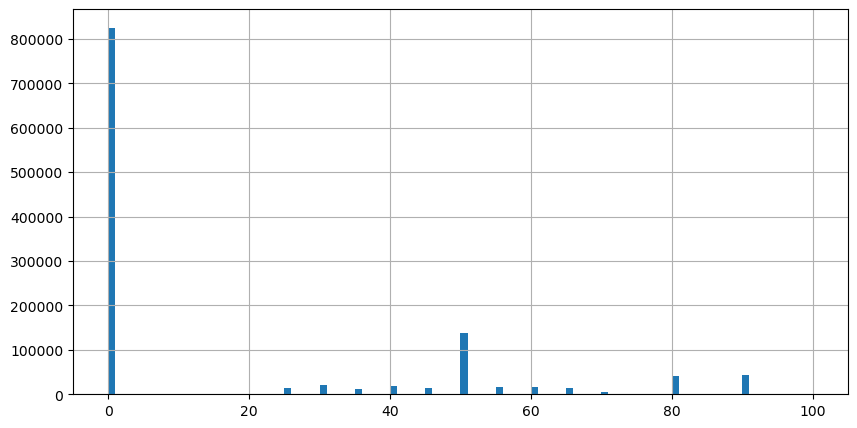

In [169]:
orders_2['teacher_age_to'].hist(bins=100, figsize=(10,5), range=(0,100)); 

In [170]:
orders_2.groupby('teacher_age_to')['teacher_age_to'].count()

teacher_age_to
-65            1
-60            1
-50            3
-10            1
-2             1
 0        825636
 3             3
 4             1
 5            32
 6             3
 8             3
 9             2
 10            1
 11            5
 12            1
 13            1
 14            2
 15            8
 16           12
 17            7
 18           32
 19           41
 20          173
 21           62
 22           92
 23          154
 24           90
 25        14356
 26          206
 27          535
 28          368
 29          114
 30        21496
 31           65
 32          184
 33          229
 34           64
 35        12739
 36          212
 37          311
 38          249
 39          103
 40        17556
 41           71
 42          143
 43          149
 44           86
 45        15232
 46          196
 47          287
 48          321
 49          121
 50       137457
 51          106
 52          247
 53          213
 54          157
 55        16322

Принимаю решение 'teacher_age_to' рассматривать от 0 до 90

In [171]:
orders_2 = orders_2.query("0 <= teacher_age_to <= 90")

## chosen_teachers_only

In [172]:
orders_2['chosen_teachers_only'].sort_values().unique()

array([0, 1], dtype=int8)

In [173]:
orders_2.groupby('chosen_teachers_only')['chosen_teachers_only'].count()

chosen_teachers_only
0    1162308
1      26577
Name: chosen_teachers_only, dtype: int64

Принимаю решение 'chosen_teachers_only' оставить как есть

In [174]:
orders_2['chosen_teachers_only'] = orders_2['chosen_teachers_only'].astype('int32')
orders_2['chosen_teachers_only'].sort_values().unique()

array([0, 1])

## no_teachers_available

In [175]:
orders_2['no_teachers_available'].sort_values().unique()

array([0, 1], dtype=int8)

In [176]:
orders_2.groupby('no_teachers_available')['no_teachers_available'].count()

no_teachers_available
0    1080809
1     108076
Name: no_teachers_available, dtype: int64

Принимаю решение 'no_teachers_available' оставить как есть

In [177]:
orders_2['no_teachers_available'] = orders_2['no_teachers_available'].astype('int32')
orders_2['no_teachers_available'].sort_values().unique()

array([0, 1])

## is_display_to_teachers

In [178]:
orders_2['is_display_to_teachers'].sort_values().unique()

array([0, 1], dtype=int8)

In [179]:
orders_2.groupby('is_display_to_teachers')['is_display_to_teachers'].count()

is_display_to_teachers
0      42661
1    1146224
Name: is_display_to_teachers, dtype: int64

In [180]:
orders_2['is_display_to_teachers'] = orders_2['is_display_to_teachers'].astype('int32')
orders_2['is_display_to_teachers'].sort_values().unique()

array([0, 1])

Принимаю решение 'is_display_to_teachers' оставить как есть

Заявки (orders_2) - ОСТАВШИЕСЯ ПРИЗНАКИ

status_id - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки) - целевой признак(конечно утечка)

order_id - id заявки - не информативный признак 

subject_id - предмет ✓
purpose - цель занятий(заполняет клиент) ✓
lesson_price - цена - 10 000 и выше - это выброс (цена ДО) ✓
lesson_duration - желаемая проодолжительность урока ✓
home_metro_id - ближайшее метро ✓
add_info - доп инфо (заполняет инфо) ✓
planned_lesson_number - клиент планирует N занятий ✓
pupil_category_new_id - возраст ученика ✓
lessons_per_week - занятий в неделю ✓
minimal_price - ЦЕНА ОТ (клиент указывает диапазон цен)-все что выше 5000 надо убрать как выброс ✓
teacher_sex - пол репетитора ✓ 1 - м, 2 - ж, 0 и 3 объединить в неизвестный
teacher_experience_from - опыт репетитора от (лет) ✓
teacher_experience_to- опыт репетитора до (лет) ✓
lesson_place_new - онлайн, у ученика, у учителя ✓
pupil_knowledgelvl -уровень знаний ученика ✓
teacher_age_from - желаемый возраст репетитора от ✓
teacher_age_to - желаемый возраст репеитора до ✓
chosen_teachers_only - не предлагать репетиторов кроме выбранных самостоятельно ✓
no_teachers_available - на заявку нет подходящих репов ✓
is_display_to_teachers - хочет ли клиент получать отклики репетиторов ✓

потом попробовать добавить эти признаки:
? не понятно значечние признака ? source_id - где создана заявка (какая часть сайта, не регион) ✓
? где этот показатель в данных, а что он означает ? coef - коэффициент ✓

# Заполнение пропусков после слияния таблиц:

In [181]:
orders_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1188885 entries, 0 to 1190959
Data columns (total 39 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   order_id                    1188885 non-null  int64  
 1   status_id                   1188885 non-null  int32  
 2   subject_id                  1188885 non-null  int32  
 3   purpose                     1188885 non-null  object 
 4   add_info                    1188885 non-null  object 
 5   lesson_price                1188885 non-null  int32  
 6   lesson_duration             1188885 non-null  int32  
 7   home_metro_id               1188885 non-null  float32
 8   planned_lesson_number       1188885 non-null  int32  
 9   pupil_category_new_id       1188885 non-null  float32
 10  lessons_per_week            1188885 non-null  int32  
 11  minimal_price               1188885 non-null  int32  
 12  teacher_sex                 1188885 non-null  int32  
 1

In [182]:
orders_2['enable_auto_assign'] = orders_2['enable_auto_assign'].fillna(0)

In [183]:
orders_2['enable_assign'] = orders_2['enable_assign'].fillna(0)

In [184]:
orders_2['birth_date'] = orders_2['birth_date'].fillna(0)

In [185]:
orders_2['is_email_confirmed'] = orders_2['birth_date'].fillna(0)

In [186]:
orders_2['status_teacher_id'] = orders_2['status_teacher_id'].fillna(0)

In [187]:
orders_2['information'] = orders_2['information'].fillna(0)

In [188]:
orders_2['is_display'] = orders_2['is_display'].fillna(0)

In [189]:
orders_2['photo_path'] = orders_2['photo_path'].fillna(0)

In [190]:
orders_2['rating'] = orders_2['rating'].fillna(0)

In [191]:
orders_2['is_cell_phone_confirmed'] = orders_2['is_cell_phone_confirmed'].fillna(0)

In [192]:
orders_2['effective_rating'] = orders_2['effective_rating'].fillna(0)

In [193]:
orders_2['rating_for_users'] = orders_2['rating_for_users'].fillna(0)

In [194]:
orders_2['rating_for_admin'] = orders_2['rating_for_admin'].fillna(0)

In [195]:
orders_2['display_days'] = orders_2['display_days'].fillna(0)

In [196]:
orders_2['star_rating'] = orders_2['star_rating'].fillna(0)

In [197]:
orders_2['rating_for_users_yesterday'] = orders_2['rating_for_users_yesterday'].fillna(0)

In [198]:
orders_2['review_num'] = orders_2['review_num'].fillna(0)

In [199]:
orders_2['purpose'] = orders_2['purpose'].astype('str')

In [200]:
orders_2['add_info'] = orders_2['add_info'].astype('str')

# Catboost

In [201]:
orders_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1188885 entries, 0 to 1190959
Data columns (total 39 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   order_id                    1188885 non-null  int64  
 1   status_id                   1188885 non-null  int32  
 2   subject_id                  1188885 non-null  int32  
 3   purpose                     1188885 non-null  object 
 4   add_info                    1188885 non-null  object 
 5   lesson_price                1188885 non-null  int32  
 6   lesson_duration             1188885 non-null  int32  
 7   home_metro_id               1188885 non-null  float32
 8   planned_lesson_number       1188885 non-null  int32  
 9   pupil_category_new_id       1188885 non-null  float32
 10  lessons_per_week            1188885 non-null  int32  
 11  minimal_price               1188885 non-null  int32  
 12  teacher_sex                 1188885 non-null  int32  
 1

In [202]:
orders_2.head()

,order_id,status_id,subject_id,purpose,add_info,lesson_price,lesson_duration,home_metro_id,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,is_display_to_teachers,enable_auto_assign,enable_assign,birth_date,is_email_confirmed,status_teacher_id,information,is_display,photo_path,rating,is_cell_phone_confirmed,effective_rating,rating_for_users,rating_for_admin,display_days,star_rating,rating_for_users_yesterday,review_num
0,2294000,0,1,0,0,0,60,0.000,0,0.000,0,0,3,0,0,0,0,0,0,0,0,1,0.059,0.059,32.231,32.231,4.462,0.385,0.923,0.769,4.154,0.000,0.621,196.500,0.000,6.346,4.539,196.500,1.615
1,2294000,0,1,0,0,0,60,0.000,0,0.000,0,0,3,0,0,0,0,0,0,0,0,1,0.059,0.059,32.231,32.231,4.462,0.385,0.923,0.769,4.154,0.000,0.621,196.500,0.000,6.346,4.539,196.500,1.615
2,2294056,0,21,Разделы: начертательная геометрия.\nКатегория ...,Место проведения занятий: дистанционно (наприм...,800,60,0.000,7,14.000,2,0,3,0,0,4,0,0,0,0,0,1,0.000,0.200,63.250,63.250,4.500,1.000,1.000,1.000,6.250,0.000,0.000,957.000,240.125,6.076,4.898,974.500,25.500
3,2293804,0,8,Разделы: школьный курс.\nКатегория ученика: ш...,Место проведения занятий: дистанционно (наприм...,700,60,0.000,10,10.000,3,0,3,5,0,4,0,20,90,0,0,1,0.000,0.000,58.667,58.667,3.000,0.667,1.000,1.000,6.667,0.000,0.000,588.500,93.312,6.108,4.965,588.500,7.667
4,2294058,0,8,0,0,0,60,122.000,0,0.000,0,0,3,0,0,2,0,0,0,0,0,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## Списки признаков

In [203]:
# создаем список количественных и качественных признаков:
numeric=[]
category = []
for col in orders_2.columns:
    if orders_2[col].dtype != 'object':
        if (orders_2[col].dtype != 'category'):
            numeric.append(col)
        else:
            category.append(col)
    else:
        category.append(col)
        
print(numeric)
print(len(numeric))
print(category)
print(len(category))

['order_id', 'status_id', 'subject_id', 'lesson_price', 'lesson_duration', 'home_metro_id', 'planned_lesson_number', 'pupil_category_new_id', 'lessons_per_week', 'minimal_price', 'teacher_sex', 'teacher_experience_from', 'teacher_experience_to', 'lesson_place_new', 'pupil_knowledgelvl', 'teacher_age_from', 'teacher_age_to', 'chosen_teachers_only', 'no_teachers_available', 'is_display_to_teachers', 'enable_auto_assign', 'enable_assign', 'birth_date', 'is_email_confirmed', 'status_teacher_id', 'information', 'is_display', 'photo_path', 'rating', 'is_cell_phone_confirmed', 'effective_rating', 'rating_for_users', 'rating_for_admin', 'display_days', 'star_rating', 'rating_for_users_yesterday', 'review_num']
37
['purpose', 'add_info']
2


In [204]:
category = ['subject_id', 'teacher_sex', 'lesson_place_new', 'chosen_teachers_only', 'no_teachers_available',\
            'is_display_to_teachers']

In [205]:
numeric= ['lesson_price', 'lesson_duration', 'planned_lesson_number', 'pupil_category_new_id',\
          'lessons_per_week', 'minimal_price', 'teacher_experience_from', 'teacher_experience_to',\
          'pupil_knowledgelvl', 'teacher_age_from', 'teacher_age_to',\
          'enable_auto_assign', 'enable_assign',\
          'birth_date', 'is_email_confirmed', 'status_teacher_id',\
          'information', 'is_display', 'photo_path', 'rating', 'is_cell_phone_confirmed', 'effective_rating',\
          'rating_for_users', 'rating_for_admin', 'display_days', 'star_rating', 'rating_for_users_yesterday',\
          'review_num']

##'home_metro_id' - не понятно как обработать эти данные

In [206]:
text_features = ['purpose', 'add_info']

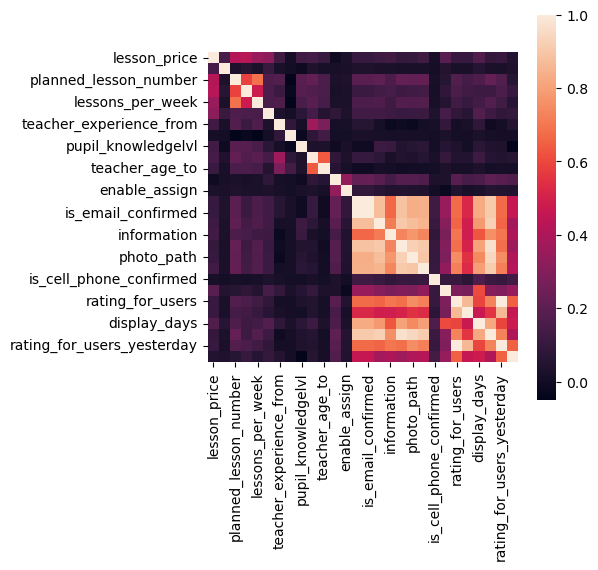

In [207]:
multi = orders_2[numeric].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(multi, square=True); # annot=True

Количественные признаки между собой линейно коррелируют слабо. Это хороший знак.

## Разделение датасета на выборки:

In [208]:
orders_2 = orders_2.drop(columns = ['order_id'], axis = 1)
orders_2 = orders_2.drop(columns = ['home_metro_id'], axis = 1)

features = orders_2.drop(columns = ['status_id'], axis = 1) # извлекаем признаки
target = orders_2['status_id'] # извлекаем целевой признак

features_train, features_test, target_train, target_test = train_test_split(
                                                           features, target, test_size=0.20, random_state=RANDOM_STATE, \
                                                           stratify=target)  

In [209]:
# проверка правильно разбиения датасета по количеству
print('Размер датасета:', orders_2.shape)
print('Размер обучающей выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер датасета: (1188885, 37)
Размер обучающей выборки: (951108, 36)
Размер тестовой выборки: (237777, 36)


## Стандартизация количественных признаков

In [210]:
scaler = StandardScaler() 
# используем ранее созданный список с количественными признаками
scaler.fit(features_train[numeric])

features_train[numeric] =scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head() # проверка визуально

,subject_id,purpose,add_info,lesson_price,lesson_duration,planned_lesson_number,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,is_display_to_teachers,enable_auto_assign,enable_assign,birth_date,is_email_confirmed,status_teacher_id,information,is_display,photo_path,rating,is_cell_phone_confirmed,effective_rating,rating_for_users,rating_for_admin,display_days,star_rating,rating_for_users_yesterday,review_num
324391,11,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,Район: Засвияжский район.\nМесто проведения за...,0.228,4.116,0.476,0.084,1.233,-0.479,2,1.272,-0.103,3,-0.459,-0.697,-0.617,0,1,1,-0.700,-0.441,-1.577,-1.577,-1.618,-1.305,-1.703,-1.647,-1.581,-0.187,-0.520,-1.197,-0.898,-1.418,-1.742,-1.197,-0.651
702357,4,Разделы: общий курс.\nКатегория ученика: школь...,"Желаемое время для занятий: понедельник - 15, ...",-0.215,-0.096,0.476,0.501,-0.010,-0.479,3,-0.526,-0.103,6,1.900,-0.697,-0.617,0,0,1,-0.570,-0.366,0.580,0.580,0.702,0.647,0.685,0.622,0.774,-0.187,-0.322,1.518,1.409,0.466,0.651,1.517,1.006
1103648,8,Разделы: школьный курс.\nКатегория ученика: у...,Район: г. Кингисепп.\nМесто проведения занятий...,-0.104,-0.096,0.476,-0.541,-0.631,0.837,3,-0.526,-0.103,2,-0.459,-0.697,-0.617,0,1,1,-0.700,-0.441,-1.577,-1.577,-1.618,-1.305,-1.703,-1.647,-1.581,-0.187,-0.520,-1.197,-0.898,-1.418,-1.742,-1.197,-0.651
678028,12,Цели: углубленное изучение.\nДополнения: ЕГЭ.\...,"Желаемое время для занятий: понедельник - 15, ...",-0.215,-0.096,0.476,0.710,-0.010,0.837,2,-0.526,-0.103,7,-0.459,0.815,2.255,0,0,1,-0.530,-0.293,0.501,0.501,0.421,0.868,0.565,0.781,0.656,0.938,0.236,1.759,1.828,0.322,0.634,1.711,1.009
398047,18,Разделы: коррекция почерка.\nКатегория ученика...,Место проведения занятий: дистанционно (наприм...,-0.658,-2.202,0.476,-0.333,-0.631,-0.479,2,-0.526,-0.103,4,-0.459,-0.697,-0.617,0,0,1,1.045,-0.441,0.254,0.254,0.318,0.255,0.593,0.687,0.578,-0.187,-0.284,0.285,0.251,-0.296,0.540,0.278,-0.409


In [211]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 951108 entries, 324391 to 348059
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   subject_id                  951108 non-null  int32  
 1   purpose                     951108 non-null  object 
 2   add_info                    951108 non-null  object 
 3   lesson_price                951108 non-null  float64
 4   lesson_duration             951108 non-null  float64
 5   planned_lesson_number       951108 non-null  float64
 6   pupil_category_new_id       951108 non-null  float64
 7   lessons_per_week            951108 non-null  float64
 8   minimal_price               951108 non-null  float64
 9   teacher_sex                 951108 non-null  int32  
 10  teacher_experience_from     951108 non-null  float64
 11  teacher_experience_to       951108 non-null  float64
 12  lesson_place_new            951108 non-null  int32  
 13  pupil_kno

## Моделирование

In [212]:
%%time

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=10) # verbose - какая кратность итериций будет выводиться для инфы

parametrs = { 'n_estimators': [500], #, 100, 200, 400        
              'max_depth': [3, 4, 5], # 2,     
               'learning_rate': [0.5]} # 0.1, 0.3, 
               #'min_samples_leaf': range (1, 5), }   # минимальное число образцов в листах
               #'min_samples_split': range (2,11,2)   # минимальное число образцов для сплита
        
grid = GridSearchCV(model, parametrs, n_jobs=-1, cv=3, scoring = 'roc_auc', verbose=3)   # запускаем обучение

grid.fit(features_train, target_train, cat_features=category, text_features = text_features)


print(grid.best_params_)   # выводим результат лучших параметров
print(grid.best_score_)   # выводим лучшее значение метрики 
table_of_results = pd.DataFrame(grid.cv_results_)
print()
table_of_results

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0:	learn: 0.5526990	total: 1.08s	remaining: 8m 58s
10:	learn: 0.4835818	total: 10.9s	remaining: 8m 5s
20:	learn: 0.4789230	total: 19.7s	remaining: 7m 30s
30:	learn: 0.4758702	total: 28.4s	remaining: 7m 9s
40:	learn: 0.4737400	total: 36.7s	remaining: 6m 50s
50:	learn: 0.4721735	total: 44.8s	remaining: 6m 34s
60:	learn: 0.4707855	total: 53s	remaining: 6m 21s
70:	learn: 0.4698544	total: 1m	remaining: 6m 8s
80:	learn: 0.4688637	total: 1m 9s	remaining: 5m 59s
90:	learn: 0.4680982	total: 1m 17s	remaining: 5m 48s
100:	learn: 0.4671949	total: 1m 25s	remaining: 5m 37s
110:	learn: 0.4664217	total: 1m 33s	remaining: 5m 26s
120:	learn: 0.4655794	total: 1m 40s	remaining: 5m 15s
130:	learn: 0.4648447	total: 1m 48s	remaining: 5m 5s
140:	learn: 0.4639128	total: 1m 56s	remaining: 4m 56s
150:	learn: 0.4631804	total: 2m 4s	remaining: 4m 46s
160:	learn: 0.4624823	total: 2m 11s	remaining: 4m 37s
170:	learn: 0.4617515	total: 2m 20s	remaining: 4m 29s

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,"1,810.590",12.874,26.200,0.770,0.500,3,500,"{'learning_rate': 0.5, 'max_depth': 3, 'n_esti...",0.756,0.757,0.756,0.756,0.000,3
1,"2,012.280",9.549,15.981,0.112,0.500,4,500,"{'learning_rate': 0.5, 'max_depth': 4, 'n_esti...",0.763,0.763,0.762,0.763,0.000,2
2,"2,043.236",12.102,6.988,1.322,0.500,5,500,"{'learning_rate': 0.5, 'max_depth': 5, 'n_esti...",0.768,0.768,0.767,0.768,0.001,1


## Тестирование

In [213]:
%%time

train_pool = Pool(features_train, target_train, cat_features = category, text_features = text_features)
test_pool = Pool(features_test, target_test, cat_features = category, text_features = text_features)

model = CatBoostClassifier(custom_loss = 'AUC', iterations= 100, depth = 3, learning_rate = 0.3, random_state=RANDOM_STATE,\
                           verbose=10) 

model.fit(train_pool, eval_set = test_pool, verbose=20)

predictions_proba = model.predict_proba(features_test) # Получим предсказания модели

print('Значение Catboost метрики roc_auc:', roc_auc_score(target_test, predictions_proba[:, 1]))

0:	learn: 0.5983386	test: 0.5984348	best: 0.5984348 (0)	total: 593ms	remaining: 58.7s
20:	learn: 0.4892050	test: 0.4902104	best: 0.4902104 (20)	total: 13.1s	remaining: 49.2s
40:	learn: 0.4817807	test: 0.4827753	best: 0.4827753 (40)	total: 25.3s	remaining: 36.4s
60:	learn: 0.4795939	test: 0.4806245	best: 0.4806245 (60)	total: 36.6s	remaining: 23.4s
80:	learn: 0.4773816	test: 0.4785722	best: 0.4785722 (80)	total: 48s	remaining: 11.3s
99:	learn: 0.4761218	test: 0.4775040	best: 0.4775040 (99)	total: 58.5s	remaining: 0us

bestTest = 0.4775040042
bestIteration = 99

Значение Catboost метрики roc_auc: 0.7391198608202151
Wall time: 1min 25s


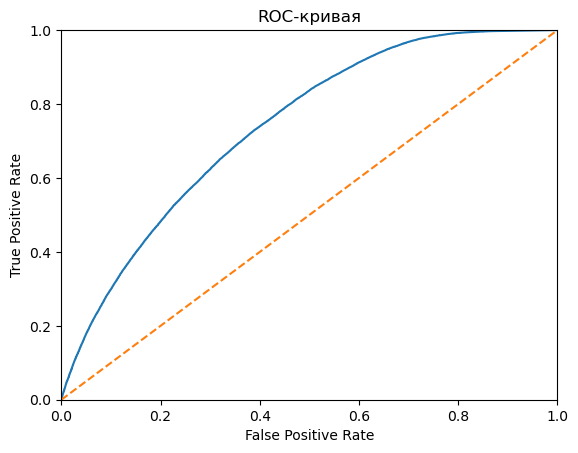

In [214]:
fpr, tpr, thresholds = roc_curve(target_test, predictions_proba[:, 1])  

plt.figure()

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0]) 

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 

plt.title('ROC-кривая')

plt.show()

## Важность признаков

In [215]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,add_info,20.661
1,no_teachers_available,18.968
2,rating_for_users_yesterday,8.233
3,birth_date,8.087
4,enable_auto_assign,6.040
5,lesson_price,5.539
6,enable_assign,4.878
7,lesson_place_new,4.289
8,rating_for_admin,4.060
9,purpose,3.576


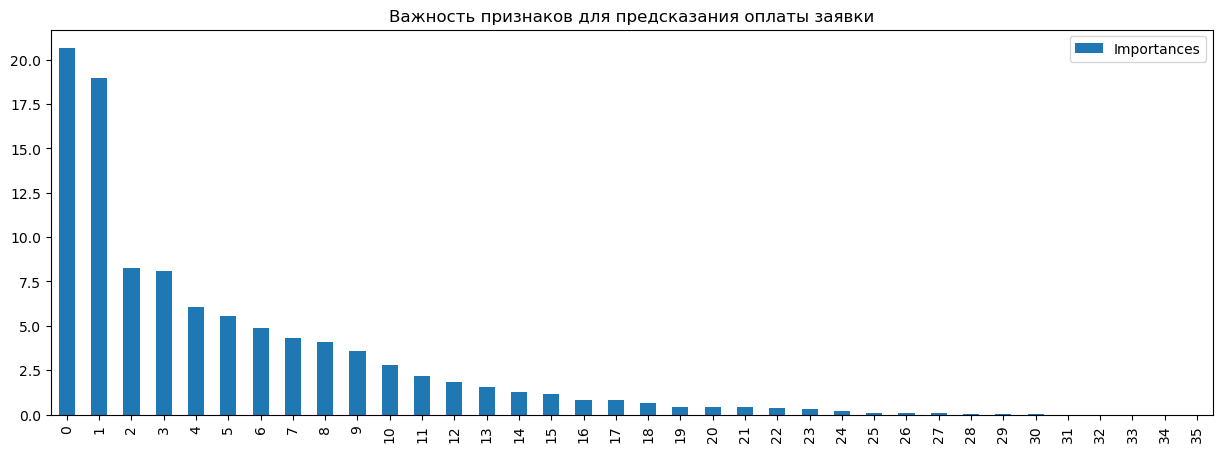

In [216]:
model.get_feature_importance(prettified=True).plot(kind='bar', figsize=(15,5)).set(title = 'Важность признаков для предсказания оплаты заявки')
plt.show()
#importances.plot(kind='bar', figsize=(15,5)).set(title = 'Важность признаков для предсказания оплаты заявки')
#plt.show();

## Итог

In [219]:
print(classification_report(target_test, model.predict(features_test)))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86    180711
           1       0.56      0.10      0.17     57066

    accuracy                           0.77    237777
   macro avg       0.67      0.54      0.52    237777
weighted avg       0.72      0.77      0.70    237777

